In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lgcg'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lgcg import LGCG

# Heat Equation

## Generate Data and Define Functions

In [42]:
# Omega = np.array([[0,1]])
# alpha = 1e-5
# observation_resolution = 9
# std_factor = 0.02
# true_sources = np.array([[0.25], [0.57], [0.77]])
# true_weights = np.array([1, 0.7, -0.7])

# Omega = np.array([[0,1], [0,1]])
# alpha = 1e-1
# observation_resolution = 4
# std_factor = 0.1
# true_sources = np.array([[0.28, 0.31], [0.51,0.73]])
# true_weights = np.array([1,1])

Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [43]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])
k = lambda x: np.array([np.exp(-np.linalg.norm(point-x)**2/std_factor)/np.sqrt(std_factor*np.pi)**Omega.shape[0] for point in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [44]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(sum(c * k(x) for x, c in zip(u.support, u.coefficients)) - target) ** 2

In [45]:
def p_raw(u, k, target):
    Ku = u.duality_pairing(k)
    inner = Ku-target
    return lambda x: -np.dot(inner, k(x))

p = lambda u: p_raw(u, k=k, target=target)

In [46]:
def grad_k_raw(observations, std_factor):
    def grad_k(x):
        return np.array([2*(point-x)*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]) for point in observations])
    return grad_k

grad_k = grad_k_raw(observations, std_factor) # The Jacobian of k, shape=(len(observations), Omega.shape[0])

In [47]:
def hess_k_raw(observations, std_factor):
    def hess_k(x):
        first_part = lambda point: -2*np.eye(Omega.shape[0])*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        second_part = lambda point: 4*np.dot((point-x).reshape(-1,1), np.array([point-x]))*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        return np.array([first_part(point)+second_part(point) for point in observations])
    return hess_k

hess_k = hess_k_raw(observations, std_factor) # The derivative of the Jacobian of k, shape=(len(observations), Omega.shape[0], Omega.shape[0])

In [48]:
# def grad_P_raw(k, target, observations, std_factor):
#     grad_k = grad_k_raw(observations, std_factor)
#     def grad_P(x,u):
#         p_u = p_raw(u, k, target)
#         inner = target-u.duality_pairing(k)
#         return np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)
#     return grad_P

# grad_P = grad_P_raw(k, target, observations, std_factor)

def grad_P_raw(u, k, target, observations, std_factor):
    grad_k = grad_k_raw(observations, std_factor)
    p_u = p_raw(u, k, target)
    inner = target-u.duality_pairing(k)
    return lambda x: np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)

grad_P = lambda u: grad_P_raw(u, k, target, observations, std_factor)

In [49]:
# def hess_P_raw(k, target, observations, std_factor):
#     hess_k = hess_k_raw(observations, std_factor)
#     def hess_P(x,u):
#         p_u = p_raw(u, k, target)
#         inner = target-u.duality_pairing(k)
#         return np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))
#     return hess_P

# hess_P = hess_P_raw(k, target, observations, std_factor)

def hess_P_raw(u, k, target, observations, std_factor):
    hess_k = hess_k_raw(observations, std_factor)
    p_u = p_raw(u, k, target)
    inner = target-u.duality_pairing(k)
    return lambda x: np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))

hess_P = lambda u: hess_P_raw(u, k, target, observations, std_factor)

In [50]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (np.array([k(x) for x in positions]).T@coefs).flatten() - target
        # grad_F = (
        #     np.sum(
        #         np.array([c * k(x) for x, c in zip(positions, coefs)]),
        #         axis=0,
        #     )
        #     - target
        # )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [51]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = (np.array([k(x) for x in positions]).T@coefs).flatten() - target
        # inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [52]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star = max(vals) # ||k([0.5,0.5])||

In [53]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(grad_k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star_L = max(vals)

In [54]:
gamma = 0.5
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-2

## Experiments

In [55]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R
           )

### Exact

In [16]:
u, P_values, times, supports, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: P_value:1.270E+01, support: [[0.44043758 0.69141257]], coefs: [1.05279812], x: [0.42427898 0.23939056]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: P_value:6.123E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: P_value:4.981E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: P_value:1.286E+00, support: [[0.141

In [17]:
best = objective_values[-1]

In [18]:
np.array(times)

array([2.38418579e-07, 7.43778229e-01, 1.45873165e+00, 2.15356541e+00,
       2.92650843e+00, 3.73898077e+00, 4.69207835e+00, 5.59868646e+00,
       6.55234647e+00, 7.44284916e+00, 8.32975268e+00, 9.38004422e+00,
       1.03865469e+01, 1.13731272e+01, 1.23133528e+01, 1.32180526e+01,
       1.41600633e+01, 1.52045908e+01, 1.61624250e+01, 1.71171250e+01,
       1.80973740e+01, 1.90641055e+01, 2.00572529e+01, 2.10248187e+01,
       2.20258045e+01, 2.29167356e+01, 2.38583360e+01, 2.47898967e+01,
       2.58070712e+01, 2.68603785e+01, 2.79471214e+01, 2.89206865e+01,
       2.98311131e+01, 3.07810290e+01, 3.17555082e+01, 3.26827385e+01,
       3.36489186e+01, 3.46675663e+01, 3.56811430e+01, 3.68206117e+01,
       3.78014596e+01, 3.88664484e+01, 3.98832567e+01, 4.07992630e+01,
       4.17194278e+01, 4.26478510e+01, 4.35925348e+01, 4.45679326e+01,
       4.55456147e+01, 4.64842255e+01, 4.74149826e+01, 4.83198383e+01,
       4.93075147e+01, 5.03942766e+01, 5.13646128e+01, 5.24199798e+01,
      

In [19]:
np.array(supports)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9,
       9, 9, 9, 9, 8, 7, 7, 8, 8, 9, 8, 8, 8, 8, 8])

In [20]:
objective_values-best

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585413e-02, 5.81289510e-02,
       5.43698661e-02, 4.28609943e-02, 2.43456500e-02, 2.24655444e-02,
       2.19692471e-02, 1.97512426e-02, 1.45352922e-02, 1.17524221e-02,
       8.37236250e-03, 8.03803967e-03, 7.27480827e-03, 5.49767003e-03,
       4.74499630e-03, 4.33283671e-03, 3.06984454e-03, 3.03428475e-03,
       2.57014239e-03, 2.25412144e-03, 2.23311058e-03, 1.77761556e-03,
       1.74648421e-03, 1.02712753e-03, 1.00858193e-03, 7.05156052e-04,
       4.57693869e-04, 3.73211746e-04, 3.33190846e-04, 3.26993463e-04,
       3.19893205e-04, 2.76246023e-04, 2.23203760e-04, 2.02453578e-04,
       1.54177783e-04, 1.15906134e-04, 8.63970888e-05, 6.07064266e-05,
       5.67247605e-05, 4.57628204e-05, 4.45962136e-05, 4.10291117e-05,
       3.04738135e-05, 1.81636873e-05, 1.30617973e-05, 1.09290597e-05,
       1.01607662e-05, 9.31992054e-06, 8.04431506e-06, 5.27257655e-06,
      

In [21]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322614 0.71433121]
 [0.28322853 0.71433151]
 [0.28322904 0.71433068]
 [0.49565803 0.23548569]
 [0.49565852 0.23548669]
 [0.49565889 0.2354857 ]
 [0.73058703 0.54790206]
 [0.73059031 0.54790021]] and coefficients [ 0.53238732  0.44742039  0.01588369 -0.22433006 -0.32025655 -0.07299411
  0.43403788  0.27809444]
3.5138558729386205e-14
-8.354428260304303e-15


### Newton

In [22]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:1: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]], grad_norm:1.000E+00, objective: 2.565E+01
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.274E-06
INFO:root:2: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.33333333 0.        ]], grad_norm:2.020E+00, objective: 2.514E+01
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 6.370E-07
INFO:root:3: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.22222222 0.11111111]
 [0.33333333 0.        ]], grad_norm:6.005E+00, objective: 2.287E+01
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 3.185E-07
INFO:root:4: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.22222222 0.11111111]
 [0.33333333 0.        ]
 [0.66666667 0.        ]], grad_norm:2.224E+01, objective: 2.259E+01
DEBUG:root:SSN in 5 dimensions converged i

In [23]:
np.array(times)

array([4.76837158e-07, 4.63771820e-03, 1.91767216e-02, 7.08298683e-02,
       1.87375069e-01, 3.32022667e-01, 4.20167446e-01, 4.96775627e-01,
       5.77177525e-01, 6.59839392e-01, 8.08284760e-01, 9.53587532e-01,
       1.06796193e+00, 1.17564893e+00, 1.31722260e+00, 1.44788837e+00,
       2.47592616e+00, 2.92618155e+00, 4.04965734e+00, 4.19949675e+00,
       4.34612584e+00, 4.42578125e+00, 5.48324513e+00, 5.55730295e+00,
       5.67098927e+00, 5.81244922e+00, 6.91170692e+00, 7.09995937e+00,
       7.27635431e+00, 7.52859282e+00, 7.64457512e+00, 7.75281715e+00,
       7.88842034e+00, 9.11615467e+00, 9.33980942e+00, 9.66656232e+00,
       9.78680611e+00, 1.01816466e+01, 1.03523026e+01, 1.15838988e+01,
       1.18943079e+01, 1.28415494e+01, 1.31266756e+01, 1.39870493e+01,
       1.48579292e+01, 1.53443072e+01, 1.61032739e+01, 1.61158946e+01,
       1.61302862e+01, 1.61328559e+01])

In [24]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  7,  7,  8,  7,  8,  8,
        9,  9,  9,  9,  8,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,  8,
        9,  8,  9,  9, 10,  9,  8,  8,  6,  4,  4,  3,  3,  3,  3,  3])

In [25]:
objective_values-best

array([ 2.56626430e+01,  2.54146720e+01,  2.49041569e+01,  2.26357120e+01,
        2.23555881e+01,  2.02797615e+01,  1.82144884e+01,  1.62748218e+01,
        9.34488771e+00,  8.65746048e+00,  5.03543706e+00,  3.18088151e+00,
        1.89578135e+00,  1.14949049e+00,  8.57799232e-01,  1.93576290e-01,
        1.38197426e-01,  1.26444699e-01,  1.11616054e-01,  9.89587558e-02,
        6.25723289e-02,  5.06042496e-02,  3.16778805e-02,  3.11363774e-02,
        2.74759752e-02,  2.29256986e-02,  2.08923850e-02,  1.84691871e-02,
        1.83128938e-02,  1.62726641e-02,  1.60306643e-02,  1.32794668e-02,
        1.28855660e-02,  5.91989682e-03,  5.85868230e-03,  5.06152038e-03,
        4.99489904e-03,  4.33074966e-03,  4.24267949e-03,  3.41832069e-03,
        1.85026074e-03,  1.51904234e-03,  6.09712693e-05,  4.35788845e-05,
        3.41449872e-06,  2.26031105e-07, -1.32954758e-12, -1.35991218e-12,
       -1.35991218e-12, -1.35991218e-12])

In [26]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
6.906974991949255e-14
-3.941291737419306e-14


In [27]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077637, 272.29702435, 194.35314107,  68.45550406,
        48.27005106,   1.82700374,   7.42624617,  18.87504406,
        24.25981579])

### Newton Damped

In [28]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=True)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:1: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]], grad_norm:1.000E+00, objective: 2.565E+01
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.274E-06
INFO:root:2: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.33333333 0.        ]], grad_norm:2.020E+00, objective: 2.514E+01
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 6.370E-07
INFO:root:3: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.22222222 0.11111111]
 [0.33333333 0.        ]], grad_norm:6.005E+00, objective: 2.287E+01
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 3.185E-07
INFO:root:4: gcg, lazy: True, merged False, support: [[0.11111111 0.        ]
 [0.22222222 0.11111111]
 [0.33333333 0.        ]
 [0.66666667 0.        ]], grad_norm:2.224E+01, objective: 2.259E+01
DEBUG:root:SSN in 5 dimensions converged i

In [29]:
np.array(times)

array([2.38418579e-07, 5.68890572e-03, 1.46663189e-02, 3.09231281e-02,
       5.03909588e-02, 8.15999508e-02, 1.29395962e-01, 2.00997829e-01,
       2.99890518e-01, 3.74899387e-01, 4.76547956e-01, 5.82543373e-01,
       7.11983919e-01, 8.25220346e-01, 9.74309683e-01, 1.13880777e+00,
       1.26242089e+00, 1.38062930e+00, 1.54976249e+00, 2.58454657e+00,
       2.74960160e+00, 3.07342410e+00, 4.07540560e+00, 4.16164708e+00,
       5.14565969e+00, 6.42795396e+00, 7.34961295e+00, 8.16080737e+00,
       8.53732586e+00, 9.33311510e+00, 1.01465061e+01, 1.09606798e+01,
       1.17864802e+01, 1.21893022e+01, 1.26171041e+01, 1.35020075e+01,
       1.39270442e+01, 1.45373566e+01, 1.54141383e+01, 1.58599856e+01,
       1.67221835e+01, 1.71139345e+01, 1.75649252e+01, 1.80212414e+01,
       1.86312666e+01, 1.95848424e+01, 2.02380495e+01, 2.08726358e+01,
       2.15758438e+01, 2.25594993e+01, 2.32309039e+01, 2.39909711e+01,
       2.47304587e+01, 2.57223766e+01, 2.61924987e+01, 2.66435363e+01,
      

In [30]:
np.array(supports)

array([0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 7,
       6, 6, 6, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7,
       8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 7, 8, 8, 8, 8, 3, 3, 3, 3, 3])

In [31]:
objective_values-best

array([ 2.56626430e+01,  2.54146720e+01,  2.49041569e+01,  2.26357120e+01,
        2.23555881e+01,  2.02797615e+01,  1.82144884e+01,  1.62748218e+01,
        9.34488771e+00,  7.05449113e+00,  4.59680136e+00,  3.47095072e+00,
        3.02604433e+00,  1.24959582e+00,  1.02588459e+00,  6.84156788e-01,
        4.99845984e-01,  3.48221343e-01,  2.45441983e-01,  1.75350891e-01,
        1.15991791e-01,  5.67959921e-02,  2.64376999e-02,  1.00111164e-02,
        3.72960187e-03,  1.29193693e-03,  5.33323753e-04,  1.46279151e-04,
        3.04646042e-05,  2.93502581e-06,  2.79466515e-06,  2.62165491e-06,
        2.50721188e-06,  1.79376223e-06,  5.82263491e-07,  5.72186261e-07,
        5.33736832e-07,  4.81355551e-07,  4.68738597e-07,  2.55813839e-07,
        2.28288354e-07,  2.19084764e-07,  1.28758402e-07,  1.05292885e-07,
        1.01774099e-07,  9.03176280e-08,  5.17841467e-08,  4.21052714e-08,
        3.78831957e-08,  3.22456968e-08,  3.10230539e-08,  2.17768445e-08,
        2.15848670e-08,  

In [32]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
2.1649348980190553e-15
-1.8596235662471372e-15


### LPDAP

In [33]:
u, Phi_ks, times, supports, objective_values = exp.solve(tol=1e-12)

INFO:root:1: N/Ax_k: True GCG, Phi_k: 16.098178357062345, epsilon: 1.2950873099134241, support: [], coefs: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 2.548E-06


INFO:root:2: Step: GCG,x_k: True GCG, Phi_k: 15.9668487035361, epsilon: 1.2950873099134241, support: [[0.11111111 0.        ]], coefs: [-0.30807342]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 2.548E-06
INFO:root:3: Step: GCG,x_k: True GCG, Phi_k: 15.527810450110735, epsilon: 1.2950873099134241, support: [[0.11111111 0.        ]
 [0.33333333 0.        ]], coefs: [ 0.42184764 -0.6537199 ]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 2.548E-06
INFO:root:4: Step: GCG,x_k: True GCG, Phi_k: 13.89122713044069, epsilon: 1.2950873099134241, support: [[0.11111111 0.        ]
 [0.22222222 0.11111111]
 [0.33333333 0.        ]], coefs: [-2.70952757  3.21643933 -2.69456397]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 2.548E-06
INFO:root:5: Step: GCG,x_k: 

In [34]:
np.array(times)

array([1.43051147e-06, 1.34468079e-02, 4.75418568e-02, 1.17383242e-01,
       1.75992489e-01, 2.32249022e-01, 2.86807060e-01, 3.59217644e-01,
       4.47192907e-01, 5.44803381e-01, 6.47532463e-01, 6.99342489e-01,
       7.66139269e-01, 8.26694012e-01, 9.07028913e-01, 9.91496801e-01,
       1.88144946e+00, 2.18876076e+00, 3.09118867e+00, 3.17250061e+00,
       3.25331926e+00, 3.33785081e+00, 3.50385451e+00, 3.82097435e+00,
       3.84484887e+00, 4.83958769e+00, 4.88640904e+00, 4.95975685e+00,
       5.05481887e+00, 6.01338410e+00, 6.11135030e+00, 6.20891690e+00,
       6.30661297e+00, 6.41155887e+00, 6.52806544e+00, 6.65609026e+00,
       6.83944654e+00, 6.88680458e+00, 6.93693376e+00, 7.01680827e+00,
       8.13390088e+00, 8.22233891e+00, 8.42600894e+00, 8.50957274e+00,
       8.59305787e+00, 8.67675877e+00, 8.92082429e+00, 9.01523829e+00,
       1.00003691e+01, 1.02924011e+01, 1.05906489e+01, 1.16328037e+01,
       1.25802629e+01, 1.35419014e+01, 1.44783528e+01, 1.47599163e+01,
      

In [35]:
np.array(supports)

array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  7,  7,  8,  7,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  8,  7,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 11,  8,  9,  8,  8,  8,  9,  9, 10,  9,  9,
        8,  8,  8,  8,  8,  7,  8,  9,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  8,  9,  8,  9,
        8,  9,  9,  8,  8,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  8,  8,
        7,  7,  8,  7,  8,  7,  7,  7,  7,  7,  6,  7,  7,  8,  9,  8,  8,
        8,  8,  7,  9,  9,  8,  8,  9,  8,  9,  9,  8,  9,  9,  8,  9, 10])

In [36]:
objective_values-best

array([ 2.56626430e+01,  2.56626430e+01,  2.54146720e+01,  2.49041569e+01,
        2.26357120e+01,  2.23555881e+01,  2.02797615e+01,  1.82144884e+01,
        1.62748218e+01,  9.34488771e+00,  8.65746048e+00,  5.03543706e+00,
        3.18088151e+00,  1.89578135e+00,  1.14949049e+00,  8.57799232e-01,
        1.93576290e-01,  1.38197428e-01,  1.26444700e-01,  1.11616053e-01,
        1.11616053e-01,  1.11616053e-01,  1.11616053e-01,  9.89587562e-02,
        6.25723295e-02,  5.06042495e-02,  3.16778815e-02,  3.11363785e-02,
        2.74759762e-02,  2.29256999e-02,  2.08923866e-02,  2.08923866e-02,
        2.08923866e-02,  2.08923866e-02,  2.08923866e-02,  1.84691886e-02,
        1.83128953e-02,  1.62726659e-02,  1.60306663e-02,  1.32794685e-02,
        1.28855679e-02,  5.91989950e-03,  5.85868503e-03,  5.06152163e-03,
        5.06152163e-03,  5.06152163e-03,  4.99490019e-03,  4.33075103e-03,
        4.24268100e-03,  3.41832148e-03,  3.41832148e-03,  1.85026013e-03,
        1.85026013e-03,  

In [37]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322656 0.7143313 ]
 [0.28322701 0.71433113]
 [0.28322748 0.71433135]
 [0.28322768 0.71433104]
 [0.49565814 0.23548624]
 [0.49565827 0.23548642]
 [0.49565842 0.23548614]
 [0.73058799 0.5479018 ]
 [0.73058806 0.54790148]
 [0.73058881 0.54790104]] and coefficients [ 0.21149885  0.03202811  0.75096038  0.00120407 -0.11536336 -0.0117709
 -0.4904464   0.09436616  0.33912827  0.27863779]
7.571721027943568e-14
6.772360450213455e-15


## Plots

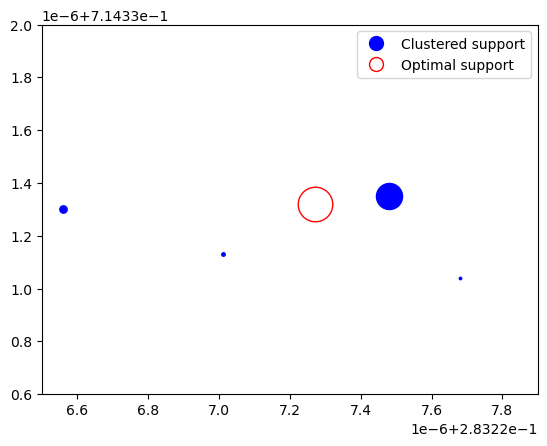

In [73]:
clustered_points = [[0.28322656, 0.7143313 ], [0.28322701, 0.71433113], [0.28322748, 0.71433135], [0.28322768, 0.71433104]]
clustered_weights = [0.21149885,  0.1,  0.75096038, 0.07]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", fillstyle="none", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", fillstyle="none", c="r", markersize=25*true_weight);
plt.ylim(7.143313e-1-7e-7, 7.143313e-1+7e-7)
plt.xlim(2.832272e-1-7e-7, 2.832272e-1+7e-7)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7fd71aa73460>


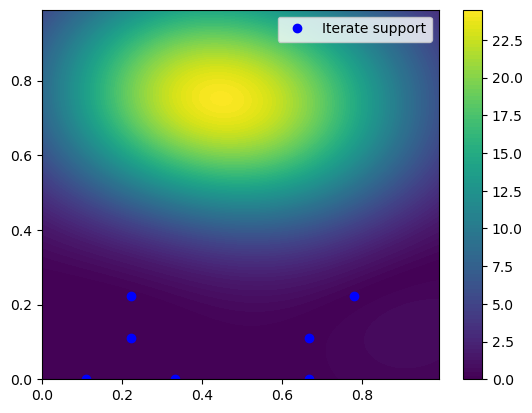

In [56]:
u_tilde = Measure(support=[[0.11111111,0],[0.22222222,0.11111111],[0.22222222,0.22222222],[0.33333333,0],[0.66666667,0],[0.66666667,0.11111111],[0.77777778,0.22222222]], coefficients=[6.30840597,-15.98011041,7.0948438,6.68288102,-0.23561619,-3.04122154,2.26782458])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        pass #plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        pass #plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Iterate support");
plt.legend();

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f7e6eb964a0>


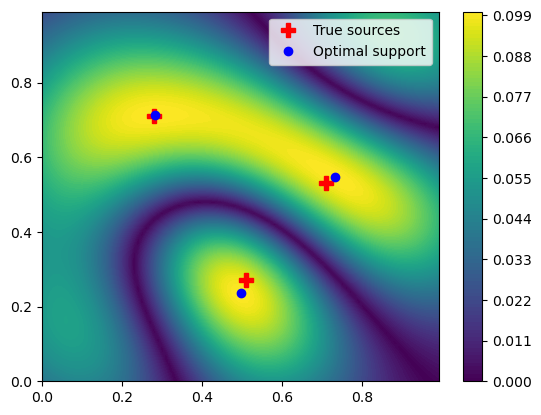

In [160]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_exact = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585413e-02, 5.81289510e-02,
       5.43698661e-02, 4.28609943e-02, 2.43456500e-02, 2.24655444e-02,
       2.19692471e-02, 1.97512426e-02, 1.45352922e-02, 1.17524221e-02,
       8.37236250e-03, 8.03803967e-03, 7.27480827e-03, 5.49767003e-03,
       4.74499630e-03, 4.33283671e-03, 3.06984454e-03, 3.03428475e-03,
       2.57014239e-03, 2.25412144e-03, 2.23311058e-03, 1.77761556e-03,
       1.74648421e-03, 1.02712753e-03, 1.00858193e-03, 7.05156052e-04,
       4.57693869e-04, 3.73211746e-04, 3.33190846e-04, 3.26993463e-04,
       3.19893205e-04, 2.76246023e-04, 2.23203760e-04, 2.02453578e-04,
       1.54177783e-04, 1.15906134e-04, 8.63970888e-05, 6.07064266e-05,
       5.67247605e-05, 4.57628204e-05, 4.45962136e-05, 4.10291117e-05,
       3.04738135e-05, 1.81636873e-05, 1.30617973e-05, 1.09290597e-05,
       1.01607662e-05, 9.31992054e-06, 8.04431506e-06, 5.27257655e-06,
       4.24380484e-06, 3.14411707e-06, 2.27084507e-06, 2.09967957e-06,
       1.54878617e-06, 1.32251384e-06, 1.21815718e-06, 7.00965723e-07,
       5.12093835e-07, 4.95815406e-07, 2.81979624e-07, 2.65762636e-07,
       2.43671652e-07, 2.04661684e-07, 1.51813866e-07, 1.42684308e-07,
       1.19827499e-07, 1.02305271e-07, 8.52871695e-08, 6.43849495e-08,
       4.03028920e-08, 3.00383047e-08, 2.80888876e-08, 2.70728227e-08,
       1.82752048e-08, 1.72073051e-08, 1.23805469e-08, 1.20002682e-08,
       1.03691407e-08, 9.08271094e-09, 4.51351659e-09, 4.09093423e-09,
       2.21293597e-09, 1.66503553e-09, 1.57368391e-09, 1.36257422e-09,
       1.23026095e-09, 6.69305278e-10, 6.16405815e-10, 5.00657571e-10,
       4.90024354e-10, 4.13456130e-10, 3.74185793e-10, 3.07097098e-10,
       2.73024631e-10, 2.65571259e-10, 1.92178745e-10, 1.46588880e-10,
       1.28412309e-10, 1.15851967e-10, 7.97252542e-11, 6.84013957e-11,
       4.77473339e-11, 4.03890810e-11, 3.74164588e-11, 2.31293595e-11,
       2.07478201e-11, 1.92425242e-11, 1.75859882e-11, 1.18211552e-11,
       3.52265439e-12, 3.01109138e-12, 2.11552997e-12, 2.02046713e-12,
       1.40581990e-12, 7.39797112e-13, 6.20087315e-13, 5.58636470e-13,
       0.00000000e+00])

times_exact = np.array([2.38418579e-07, 6.12273216e-01, 1.25772405e+00, 1.99518347e+00,
       2.73003459e+00, 3.47527814e+00, 4.25426865e+00, 5.09331417e+00,
       5.94853377e+00, 6.83770609e+00, 7.63093114e+00, 8.45507932e+00,
       9.33001900e+00, 1.02170548e+01, 1.10674608e+01, 1.19047310e+01,
       1.27698171e+01, 1.36800284e+01, 1.45787954e+01, 1.54769354e+01,
       1.63643103e+01, 1.72201703e+01, 1.81369667e+01, 1.91024094e+01,
       1.99493012e+01, 2.08266158e+01, 2.17420287e+01, 2.26437120e+01,
       2.35754960e+01, 2.45058439e+01, 2.54262092e+01, 2.62979453e+01,
       2.71535795e+01, 2.80282147e+01, 2.89412351e+01, 2.98101647e+01,
       3.07539864e+01, 3.16672328e+01, 3.25623279e+01, 3.34894431e+01,
       3.43799818e+01, 3.53103337e+01, 3.61655068e+01, 3.71037271e+01,
       3.80582592e+01, 3.90282204e+01, 4.01416256e+01, 4.10868914e+01,
       4.21594737e+01, 4.30782568e+01, 4.39781358e+01, 4.48437402e+01,
       4.57153397e+01, 4.66304376e+01, 4.75474145e+01, 4.84592857e+01,
       4.93922749e+01, 5.03391771e+01, 5.12487702e+01, 5.21593409e+01,
       5.30767810e+01, 5.39793351e+01, 5.48971658e+01, 5.58193855e+01,
       5.67267489e+01, 5.76445243e+01, 5.85246515e+01, 5.94092326e+01,
       6.02835104e+01, 6.11565697e+01, 6.20281758e+01, 6.29825897e+01,
       6.39714346e+01, 6.50595829e+01, 6.59590025e+01, 6.68627963e+01,
       6.77254541e+01, 6.86005063e+01, 6.94295630e+01, 7.02977779e+01,
       7.11942391e+01, 7.21083879e+01, 7.30198381e+01, 7.39244223e+01,
       7.48358779e+01, 7.57689734e+01, 7.66848397e+01, 7.76277246e+01,
       7.85312574e+01, 7.94745493e+01, 8.03995912e+01, 8.14486027e+01,
       8.23833959e+01, 8.32758927e+01, 8.41516273e+01, 8.50384364e+01,
       8.59151597e+01, 8.68615887e+01, 8.79806280e+01, 8.90651779e+01,
       9.00566080e+01, 9.10018537e+01, 9.19416044e+01, 9.28798959e+01,
       9.37640901e+01, 9.46771679e+01, 9.56976199e+01, 9.66751268e+01,
       9.76611512e+01, 9.88131630e+01, 9.98281744e+01, 1.00979978e+02,
       1.02057386e+02, 1.03013105e+02, 1.04090210e+02, 1.05079189e+02,
       1.05918302e+02, 1.06830826e+02, 1.07777877e+02, 1.08781806e+02,
       1.09893294e+02, 1.10947534e+02, 1.11952928e+02, 1.12969727e+02,
       1.13890296e+02])

supports_exact = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9,
       9, 9, 9, 9, 8, 7, 7, 8, 8, 9, 8, 8, 8, 8, 8])

residuals_newton = np.array([ 2.56626430e+01,  2.54146720e+01,  2.49041569e+01,  2.26357120e+01,
        2.23555881e+01,  2.02797615e+01,  1.82144884e+01,  1.62748218e+01,
        9.34488771e+00,  8.65746048e+00,  5.03543706e+00,  3.18088151e+00,
        1.89578135e+00,  1.14949049e+00,  8.57799232e-01,  1.93576290e-01,
        1.38197426e-01,  1.26444699e-01,  1.11616054e-01,  9.89587558e-02,
        6.25723289e-02,  5.06042496e-02,  3.16778805e-02,  3.11363774e-02,
        2.74759752e-02,  2.29256986e-02,  2.08923850e-02,  1.84691871e-02,
        1.83128938e-02,  1.62726641e-02,  1.60306643e-02,  1.32794668e-02,
        1.28855660e-02,  5.91989682e-03,  5.85868230e-03,  5.06152038e-03,
        4.99489904e-03,  4.33074966e-03,  4.24267949e-03,  3.41832069e-03,
        1.85026074e-03,  1.51904234e-03,  6.09712693e-05,  4.35788845e-05,
        3.41449872e-06,  2.26031105e-07, -1.32954758e-12, -1.35991218e-12,
       -1.35991218e-12])

times_newton = np.array([4.76837158e-07, 4.63771820e-03, 1.91767216e-02, 7.08298683e-02,
       1.87375069e-01, 3.32022667e-01, 4.20167446e-01, 4.96775627e-01,
       5.77177525e-01, 6.59839392e-01, 8.08284760e-01, 9.53587532e-01,
       1.06796193e+00, 1.17564893e+00, 1.31722260e+00, 1.44788837e+00,
       2.47592616e+00, 2.92618155e+00, 4.04965734e+00, 4.19949675e+00,
       4.34612584e+00, 4.42578125e+00, 5.48324513e+00, 5.55730295e+00,
       5.67098927e+00, 5.81244922e+00, 6.91170692e+00, 7.09995937e+00,
       7.27635431e+00, 7.52859282e+00, 7.64457512e+00, 7.75281715e+00,
       7.88842034e+00, 9.11615467e+00, 9.33980942e+00, 9.66656232e+00,
       9.78680611e+00, 1.01816466e+01, 1.03523026e+01, 1.15838988e+01,
       1.18943079e+01, 1.28415494e+01, 1.31266756e+01, 1.39870493e+01,
       1.48579292e+01, 1.53443072e+01, 1.61032739e+01, 1.61158946e+01,
       1.61302862e+01])

supports_newton = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  7,  7,  8,  7,  8,  8,
        9,  9,  9,  9,  8,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,  8,
        9,  8,  9,  9, 10,  9,  8,  8,  6,  4,  4,  3,  3,  3,  3])

residuals_newton_damped = np.array([ 2.56626430e+01,  2.54146720e+01,  2.49041569e+01,  2.26357120e+01,
        2.23555881e+01,  2.02797615e+01,  1.82144884e+01,  1.62748218e+01,
        9.34488771e+00,  7.05449113e+00,  4.59680136e+00,  3.47095072e+00,
        3.02604433e+00,  1.24959582e+00,  1.02588459e+00,  6.84156788e-01,
        4.99845984e-01,  3.48221343e-01,  2.45441983e-01,  1.75350891e-01,
        1.15991791e-01,  5.67959921e-02,  2.64376999e-02,  1.00111164e-02,
        3.72960187e-03,  1.29193693e-03,  5.33323753e-04,  1.46279151e-04,
        3.04646042e-05,  2.93502581e-06,  2.79466515e-06,  2.62165491e-06,
        2.50721188e-06,  1.79376223e-06,  5.82263491e-07,  5.72186261e-07,
        5.33736832e-07,  4.81355551e-07,  4.68738597e-07,  2.55813839e-07,
        2.28288354e-07,  2.19084764e-07,  1.28758402e-07,  1.05292885e-07,
        1.01774099e-07,  9.03176280e-08,  5.17841467e-08,  4.21052714e-08,
        3.78831957e-08,  3.22456968e-08,  3.10230539e-08,  2.17768445e-08,
        2.15848670e-08,  2.05752755e-08,  1.72004133e-08,  1.69032750e-08,
        1.39981909e-08,  1.25184569e-08,  8.80413401e-09,  2.33337091e-09,
       -1.35474965e-12, -1.35991218e-12, -1.35993994e-12])

times_newton_damped = np.array([2.38418579e-07, 5.68890572e-03, 1.46663189e-02, 3.09231281e-02,
       5.03909588e-02, 8.15999508e-02, 1.29395962e-01, 2.00997829e-01,
       2.99890518e-01, 3.74899387e-01, 4.76547956e-01, 5.82543373e-01,
       7.11983919e-01, 8.25220346e-01, 9.74309683e-01, 1.13880777e+00,
       1.26242089e+00, 1.38062930e+00, 1.54976249e+00, 2.58454657e+00,
       2.74960160e+00, 3.07342410e+00, 4.07540560e+00, 4.16164708e+00,
       5.14565969e+00, 6.42795396e+00, 7.34961295e+00, 8.16080737e+00,
       8.53732586e+00, 9.33311510e+00, 1.01465061e+01, 1.09606798e+01,
       1.17864802e+01, 1.21893022e+01, 1.26171041e+01, 1.35020075e+01,
       1.39270442e+01, 1.45373566e+01, 1.54141383e+01, 1.58599856e+01,
       1.67221835e+01, 1.71139345e+01, 1.75649252e+01, 1.80212414e+01,
       1.86312666e+01, 1.95848424e+01, 2.02380495e+01, 2.08726358e+01,
       2.15758438e+01, 2.25594993e+01, 2.32309039e+01, 2.39909711e+01,
       2.47304587e+01, 2.57223766e+01, 2.61924987e+01, 2.66435363e+01,
       2.71588778e+01, 2.77460613e+01, 2.84472852e+01, 2.94582283e+01,
       2.95495665e+01, 2.95605881e+01, 2.95732975e+01])

supports_newton_damped = np.array([0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 7,
       6, 6, 6, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7,
       8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 7, 8, 8, 8, 8, 3, 3, 3, 3])

residuals_lpdap = np.array([ 2.56626430e+01,  2.56626430e+01,  2.54146720e+01,  2.49041569e+01,
        2.26357120e+01,  2.23555881e+01,  2.02797615e+01,  1.82144884e+01,
        1.62748218e+01,  9.34488771e+00,  8.65746048e+00,  5.03543706e+00,
        3.18088151e+00,  1.89578135e+00,  1.14949049e+00,  8.57799232e-01,
        1.93576290e-01,  1.38197428e-01,  1.26444700e-01,  1.11616053e-01,
        1.11616053e-01,  1.11616053e-01,  1.11616053e-01,  9.89587562e-02,
        6.25723295e-02,  5.06042495e-02,  3.16778815e-02,  3.11363785e-02,
        2.74759762e-02,  2.29256999e-02,  2.08923866e-02,  2.08923866e-02,
        2.08923866e-02,  2.08923866e-02,  2.08923866e-02,  1.84691886e-02,
        1.83128953e-02,  1.62726659e-02,  1.60306663e-02,  1.32794685e-02,
        1.28855679e-02,  5.91989950e-03,  5.85868503e-03,  5.06152163e-03,
        5.06152163e-03,  5.06152163e-03,  4.99490019e-03,  4.33075103e-03,
        4.24268100e-03,  3.41832148e-03,  3.41832148e-03,  1.85026013e-03,
        1.85026013e-03,  1.85026013e-03,  1.85026013e-03,  1.51904212e-03,
        1.36263216e-03,  1.27501314e-03,  1.26973525e-03,  1.00328693e-03,
        8.88517445e-04,  8.86269853e-04,  8.78979444e-04,  6.40462394e-04,
        6.35109318e-04,  5.68038240e-04,  5.68038240e-04,  5.68038240e-04,
        5.68038240e-04,  5.68038240e-04,  5.68038240e-04,  4.97344314e-04,
        4.77492956e-04,  3.52371401e-04,  3.27651843e-04,  2.06972680e-04,
        2.00576207e-04,  2.00576207e-04,  1.41174367e-04,  1.41174367e-04,
        7.00942274e-05,  4.96560668e-05,  3.56737968e-05,  2.60850465e-05,
        1.48048591e-05,  1.38785561e-05,  1.38785561e-05,  1.38785561e-05,
        1.38785561e-05,  1.26992534e-05,  1.19964058e-05,  8.05728024e-06,
        7.32259500e-06,  6.15718561e-06,  6.06094704e-06,  4.15967517e-06,
        4.01428501e-06,  3.54726885e-06,  3.15993258e-06,  3.08345802e-06,
        2.50321270e-06,  2.43662837e-06,  1.43914934e-06,  1.33575892e-06,
        1.22819586e-06,  1.06514228e-06,  8.79359482e-07,  6.90054567e-07,
        5.62964798e-07,  4.53377171e-07,  2.46722356e-07,  2.10959897e-07,
        1.34525439e-07,  3.92428015e-08,  2.50597939e-08,  1.77409654e-08,
        1.49434126e-08,  1.44812699e-08,  1.25000864e-08,  2.48972234e-09,
        1.88569471e-09,  8.51793192e-10,  7.45671691e-10,  5.32783095e-10,
        2.81123375e-10,  2.62190880e-10,  2.34249786e-10,  1.41239631e-10,
        1.07401227e-10,  4.22331059e-11,  4.19847490e-11,  2.62167232e-11,
        1.95026217e-11,  1.22331589e-11,  1.05851716e-11,  8.43070058e-12,
        7.96321342e-12,  6.86928292e-12,  4.94601582e-12,  2.78543855e-12,
        2.15769069e-12,  8.12405698e-13,  2.10609308e-13,  1.32560629e-13,
       -5.12340170e-13, -7.70133957e-13, -8.48154880e-13, -1.04283249e-12,
       -1.05940257e-12, -1.19296240e-12, -1.24794619e-12, -1.25249811e-12,
       -1.25591204e-12])

times_lpdap = np.array([1.43051147e-06, 1.34468079e-02, 4.75418568e-02, 1.17383242e-01,
       1.75992489e-01, 2.32249022e-01, 2.86807060e-01, 3.59217644e-01,
       4.47192907e-01, 5.44803381e-01, 6.47532463e-01, 6.99342489e-01,
       7.66139269e-01, 8.26694012e-01, 9.07028913e-01, 9.91496801e-01,
       1.88144946e+00, 2.18876076e+00, 3.09118867e+00, 3.17250061e+00,
       3.25331926e+00, 3.33785081e+00, 3.50385451e+00, 3.82097435e+00,
       3.84484887e+00, 4.83958769e+00, 4.88640904e+00, 4.95975685e+00,
       5.05481887e+00, 6.01338410e+00, 6.11135030e+00, 6.20891690e+00,
       6.30661297e+00, 6.41155887e+00, 6.52806544e+00, 6.65609026e+00,
       6.83944654e+00, 6.88680458e+00, 6.93693376e+00, 7.01680827e+00,
       8.13390088e+00, 8.22233891e+00, 8.42600894e+00, 8.50957274e+00,
       8.59305787e+00, 8.67675877e+00, 8.92082429e+00, 9.01523829e+00,
       1.00003691e+01, 1.02924011e+01, 1.05906489e+01, 1.16328037e+01,
       1.25802629e+01, 1.35419014e+01, 1.44783528e+01, 1.47599163e+01,
       1.49564590e+01, 1.50469787e+01, 1.53737214e+01, 1.56688285e+01,
       1.57866964e+01, 1.61317656e+01, 1.71266448e+01, 1.76344018e+01,
       1.79587727e+01, 1.89568744e+01, 1.98671701e+01, 2.08256471e+01,
       2.17377954e+01, 2.26635654e+01, 2.35949781e+01, 2.38283947e+01,
       2.40994365e+01, 2.45821538e+01, 2.52341979e+01, 2.57575822e+01,
       2.67418289e+01, 2.77182488e+01, 2.77412312e+01, 2.77669969e+01,
       2.78036432e+01, 2.87815733e+01, 2.88159931e+01, 2.97153800e+01,
       2.97503388e+01, 2.97849929e+01, 2.98109107e+01, 2.98366263e+01,
       2.98751199e+01, 2.99173949e+01, 3.08858185e+01, 3.09190252e+01,
       3.09544835e+01, 3.09889054e+01, 3.10242128e+01, 3.20375443e+01,
       3.20974278e+01, 3.21402862e+01, 3.21767747e+01, 3.31953366e+01,
       3.32492259e+01, 3.33041329e+01, 3.33445895e+01, 3.33757231e+01,
       3.34098604e+01, 3.43676329e+01, 3.44009919e+01, 3.44345429e+01,
       3.44757943e+01, 3.56286638e+01, 3.56686645e+01, 3.66974759e+01,
       3.67396045e+01, 3.78302488e+01, 3.78857079e+01, 3.79228518e+01,
       3.89634924e+01, 3.90162475e+01, 3.90531299e+01, 3.99544284e+01,
       3.99831645e+01, 4.00208027e+01, 4.09032505e+01, 4.18232756e+01,
       4.18653858e+01, 4.18942049e+01, 4.27676473e+01, 4.27976243e+01,
       4.28314719e+01, 4.28671319e+01, 4.37633989e+01, 4.37929363e+01,
       4.38314309e+01, 4.48070807e+01, 4.48413520e+01, 4.48730230e+01,
       4.57941148e+01, 4.58298564e+01, 4.58649733e+01, 4.59002008e+01,
       4.59438639e+01, 4.59866986e+01, 4.60186524e+01, 4.70226657e+01,
       4.70591753e+01, 4.80728676e+01, 4.81092012e+01, 4.90753028e+01,
       4.91069050e+01, 4.91482656e+01, 4.91813219e+01, 4.92361047e+01,
       5.04417572e+01])

supports_lpdap = np.array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  7,  7,  8,  7,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  8,  7,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 11,  8,  9,  8,  8,  8,  9,  9, 10,  9,  9,
        8,  8,  8,  8,  8,  7,  8,  9,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  8,  9,  8,  9,
        8,  9,  9,  8,  8,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  8,  8,
        7,  7,  8,  7,  8,  7,  7,  7,  7,  7,  6,  7,  7,  8,  9,  8,  8,
        8,  8,  7,  9,  9,  8,  8,  9,  8,  9,  9,  8,  9,  9,  8,  9, 10])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 26);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_exact, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_exact, times_lpdap, times_newton, times_newton_damped], [residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 26);
plt.legend();

# Signal Processing

## Generate Data and Define Functions

In [57]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [58]:
observations = np.arange(0,1,1/observation_resolution)
k = lambda x: np.array([np.sin(2*np.pi*x[0]*t) for t in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [59]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(k) - target) ** 2

In [60]:
def p_raw(u, k, target):
    Ku = u.duality_pairing(k)
    inner = Ku-target
    return lambda x: -np.dot(inner, k(x))

p = lambda u: p_raw(u, k=k, target=target)

In [61]:
def grad_k_raw(observations):
    def grad_k(x):
        return np.array([[2*np.pi*t*np.cos(2*np.pi*x[0]*t) for t in observations]]).T
    return grad_k

grad_k = grad_k_raw(observations) # The Jacobian of k, shape=(len(observations),Omega.shape[0])

In [62]:
def hess_k_raw(observations):
    def hess_k(x):
        return np.transpose(np.array([[[-4*np.pi**2*t**2*np.sin(2*np.pi*x[0]*t) for t in observations]]]), axes=(2,0,1))
    return hess_k

hess_k = hess_k_raw(observations) # The Hessian of k, shape=(len(observations),Omega.shape[0],Omega.shape[0])

In [63]:
# def grad_P_raw(k, target, observations):
#     grad_k = grad_k_raw(observations)
#     def grad_P(x,u):
#         p_u = p_raw(u, k, target)
#         inner = target-u.duality_pairing(k)
#         return np.array(np.sign(p_u(x))*np.matmul(grad_k(x).T, inner))
#     return grad_P

# grad_P = grad_P_raw(k, target, observations)

def grad_P_raw(u, k, target, observations):
    grad_k = grad_k_raw(observations)
    p_u = p_raw(u, k, target)
    inner = target-u.duality_pairing(k)
    return lambda x: np.array(np.sign(p_u(x))*np.matmul(grad_k(x).T, inner))

grad_P = lambda u: grad_P_raw(u, k, target, observations)

In [64]:
# def hess_P_raw(k, target, observations):
#     hess_k = hess_k_raw(observations)
#     def hess_P(x,u):
#         p_u = p_raw(u, k, target)
#         inner = target-u.duality_pairing(k)
#         return np.array(np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0])))
#     return hess_P

# hess_P = hess_P_raw(k, target, observations)

def hess_P_raw(u, k, target, observations):
    hess_k = hess_k_raw(observations)
    p_u = p_raw(u, k, target)
    inner = target-u.duality_pairing(k)
    return lambda x: np.array(np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0])))

hess_P = lambda u: hess_P_raw(u, k, target, observations)

In [65]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (np.array([k(x) for x in positions]).T@coefs).flatten() - target
        # grad_F = (
        #     np.sum(
        #         np.array([c * k(x) for x, c in zip(positions, coefs)]),
        #         axis=0,
        #     )
        #     - target
        # )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [66]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = (np.array([k(x) for x in positions]).T@coefs).flatten() - target # sum(k(x)*c for c, x in zip(coefs, positions))
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [67]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(k(np.array([x]))) for x in a]
norm_K_star = max(vals)

In [68]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
norm_K_star_L = max(vals)

In [69]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-1

## Experiments

In [70]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R,
           global_search_resolution=observation_resolution
           )

### Exact

In [16]:
u, P_values, times, supports, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: P_value:4.205E+01, support: [[3.13588856]], coefs: [-1.02219696], x: [7.00005078]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:2: P_value:2.994E+01, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], x: [13.38203765]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:3: P_value:1.804E+00, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], x: [2.81555416]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: P_value:7.835E-01, support: [[ 2.81555416]
 [ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.03816109 -0.97952737  0.6985

In [17]:
best = objective_values[-1]

In [18]:
np.array(times)

array([7.15255737e-07, 9.69273806e-01, 2.06284642e+00, 3.10798287e+00,
       4.28800249e+00, 5.52202249e+00, 6.86788750e+00, 8.29944587e+00,
       9.85551786e+00, 1.15685759e+01, 1.33826592e+01, 1.50327451e+01,
       1.66631343e+01, 1.82392566e+01, 1.96195352e+01, 2.12964072e+01,
       2.26654823e+01, 2.38493247e+01, 2.54121101e+01, 2.67347274e+01,
       2.78967409e+01, 2.91238983e+01, 3.03903918e+01, 3.15941803e+01,
       3.28293891e+01, 3.43849096e+01, 3.58746297e+01, 3.72971690e+01,
       3.84891591e+01, 3.97099314e+01, 4.09229777e+01, 4.22555859e+01,
       4.34967346e+01, 4.49591880e+01, 4.63630192e+01, 4.75573509e+01,
       4.87809379e+01, 5.00362239e+01, 5.12775805e+01, 5.26274550e+01,
       5.38373880e+01, 5.51166923e+01, 5.64070711e+01, 5.76078711e+01,
       5.88325696e+01, 6.01033633e+01, 6.14623339e+01, 6.26738141e+01,
       6.39376607e+01, 6.51062777e+01, 6.63683684e+01, 6.76065805e+01,
       6.88461199e+01, 7.00978251e+01, 7.15518222e+01, 7.27830379e+01,
      

In [19]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [20]:
objective_values-best

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       1.50239772e-02, 8.58376237e-03, 6.60215195e-03, 6.26160449e-03,
       5.81056950e-03, 5.68714547e-03, 5.63453907e-03, 2.74798164e-03,
       2.49625303e-03, 2.43692851e-03, 1.09428954e-03, 1.06241336e-03,
       9.64583819e-04, 3.70010637e-04, 3.28227678e-04, 3.27716469e-04,
       1.08225413e-04, 8.89059416e-05, 8.85996710e-05, 2.08580979e-05,
       1.15859840e-05, 1.14112323e-05, 8.58446119e-06, 4.06824142e-06,
       3.96465096e-06, 2.55842018e-06, 1.39500283e-06, 1.33895562e-06,
       6.37729467e-07, 3.72189841e-07, 3.43277460e-07, 1.86415811e-07,
       1.07769274e-07, 9.30277860e-08, 4.47893356e-08, 3.13003693e-08,
       2.38715822e-08, 1.63305323e-08, 9.86911175e-09, 6.13658044e-09,
       2.36081441e-09, 2.29146599e-09, 4.21193497e-10, 3.30606542e-10,
       2.94933439e-10, 1.95398475e-10, 1.49766199e-10, 1.31618577e-10,
       8.15619794e-11, 5.86620474e-11, 4.95105901e-11, 2.44100018e-11,
      

In [21]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502047]
 [ 3.12502291]
 [ 6.99999239]
 [ 6.99999441]
 [13.37905522]
 [13.37905744]] and coefficients [-0.48318053 -0.51514675  0.62617145  0.07224146  0.21164941  0.28668766]
3.8441472227646045e-14
-2.2037927038809357e-14


### Newton

In [22]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 3.512E-05


INFO:root:1: gcg, lazy: True, merged False, support: [[2.01680672]], grad_norm:1.000E+00, objective: 5.278E+01
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.756E-05
INFO:root:2: gcg, lazy: True, merged False, support: [[2.01680672]
 [2.5210084 ]], grad_norm:2.297E+00, objective: 5.221E+01
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 8.781E-06
INFO:root:3: gcg, lazy: True, merged False, support: [[2.01680672]
 [2.5210084 ]
 [3.02521008]], grad_norm:9.129E+00, objective: 2.685E+01
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 3.512E-05
INFO:root:4: newton, lazy: True, merged False, support: [[2.15647051]
 [2.72423626]
 [3.162081  ]], grad_norm:6.643E+01, objective: 2.269E+01
DEBUG:root:SSN in 3 dimensions converged in 5 iterations to tolerance 3.512E-05
INFO:root:5: newton, lazy: True, merged False, support: [[2.60501959]
 [2.89649918]
 [3.15580437]], grad_norm:1.311E+01, objective: 2.257E+01
DEBUG:root:SSN in 3 d

In [23]:
np.array(times)

array([1.19209290e-06, 3.50530148e-02, 7.65721798e-02, 1.00760698e-01,
       1.40667200e-01, 1.93369150e-01, 2.26628065e-01, 2.60476351e-01,
       2.87328482e-01, 3.27580214e-01, 3.87232065e-01, 4.86147881e-01,
       6.57824755e-01, 7.84966707e-01, 8.73430967e-01, 9.55430984e-01,
       1.05128646e+00, 1.15954590e+00, 1.28845143e+00, 1.41336656e+00,
       3.33861947e+00, 5.16587710e+00, 5.95931125e+00, 8.06714368e+00,
       8.24223781e+00, 9.68999267e+00, 9.87122107e+00, 1.00135257e+01,
       1.01871917e+01, 1.03679237e+01, 1.05610576e+01, 1.07831032e+01,
       1.10229323e+01, 1.12856801e+01, 1.15844924e+01, 1.19650075e+01,
       1.23209784e+01, 1.26941075e+01, 1.31377363e+01, 1.35878024e+01,
       1.41198969e+01, 1.45857699e+01, 1.84010417e+01, 1.88914170e+01,
       1.95119765e+01, 2.07631366e+01, 2.20712292e+01, 2.33722093e+01,
       2.39961178e+01, 2.83172612e+01, 2.88574896e+01, 2.94551344e+01,
       3.07134571e+01, 3.28022921e+01, 3.40351858e+01, 3.59654481e+01,
      

In [24]:
np.array(supports)

array([ 0,  1,  2,  3,  3,  3,  3,  4,  5,  5,  6,  6,  7,  6,  7,  8,  9,
       10, 10, 10, 11, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 18, 19, 20,
       20, 21, 22, 22, 22, 23, 24, 24, 25, 26, 27, 28, 28, 27, 28, 26, 27,
       28, 28, 28, 28, 26, 27, 27, 21, 19, 17, 17, 17, 17, 18, 18, 18, 10,
       11, 12, 13, 14, 10, 10, 11, 12, 12, 13,  7,  5,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3])

In [25]:
objective_values-best

array([ 5.26929402e+01,  5.25620964e+01,  5.19870574e+01,  2.66276636e+01,
        2.24656226e+01,  2.23488531e+01,  2.22822380e+01,  2.20759943e+01,
        2.19514573e+01,  7.81828368e+00,  7.61331170e+00,  7.53508611e+00,
        7.45494061e+00,  7.51579966e+00,  7.39070991e+00,  7.07078834e+00,
        4.46967845e+00,  1.08436022e+00,  2.31045645e-01,  7.52489244e-02,
        4.03248275e-02,  3.32303530e-02,  3.13475816e-02,  3.00792392e-02,
        2.97608280e-02,  2.94543304e-02,  1.32952023e-01,  1.32632966e-01,
        1.31233459e-01,  1.26893317e-01,  1.25355805e-01,  1.18524340e-01,
        1.18248894e-01,  6.88252791e-02,  5.60988681e-02,  5.52574064e-02,
        5.42353627e-02,  5.25909403e-02,  5.06021111e-02,  4.89638581e-02,
        4.76547193e-02,  4.64563525e-02,  4.62013235e-02,  4.61208541e-02,
        4.60494976e-02,  4.59625504e-02,  4.21117135e-02,  3.84046185e-02,
        3.83263079e-02,  3.68536228e-02,  3.68069427e-02,  3.67882111e-02,
        3.63082252e-02,  

In [26]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
3.191891195797325e-15
-1.2490009027033011e-15


In [27]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.911190176961407e-05
0.0028429187726321504


In [28]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400003, 377.40347866, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

### Newton Damped

In [72]:
u, grad_norms, times, supports, objective_values = exp.solve_newton(tol=1e-12, damped=True)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:1: gcg, lazy: True, merged False, support: [[2.01680672]], grad_norm:1.000E+00, objective: 5.278E+01
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.756E-05
INFO:root:2: gcg, lazy: True, merged False, support: [[2.01680672]
 [2.5210084 ]], grad_norm:2.297E+00, objective: 5.221E+01
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 8.781E-06
INFO:root:3: gcg, lazy: True, merged False, support: [[2.01680672]
 [2.5210084 ]
 [3.02521008]], grad_norm:9.129E+00, objective: 2.685E+01
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:4: newton, lazy: True, merged False, support: [[2.02840957]
 [2.53789196]
 [3.03658091]], grad_norm:6.643E+01, objective: 2.597E+01
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:5: newton, lazy: True, merged False, support: [[2.03833441]
 [2.55302905]

In [30]:
np.array(times)

array([2.38418579e-07, 5.88369370e-03, 1.63602829e-02, 3.94928455e-02,
       7.92682171e-02, 1.24153137e-01, 1.67681694e-01, 2.10823298e-01,
       2.52783537e-01, 2.95815945e-01, 3.38614702e-01, 3.78114223e-01,
       4.17295218e-01, 4.62554216e-01, 5.04990339e-01, 5.49395323e-01,
       5.94838858e-01, 6.38618469e-01, 6.95864201e-01, 7.26849079e-01,
       7.81159401e-01, 8.50107193e-01, 9.19887304e-01, 1.00283051e+00,
       1.11591029e+00, 1.24646115e+00, 1.39396429e+00, 1.55571365e+00,
       1.72874546e+00, 1.90935731e+00, 2.12030363e+00, 2.33188939e+00,
       2.94162989e+00, 5.23218584e+00, 5.46177506e+00, 5.71456528e+00,
       6.41008353e+00, 7.26161218e+00, 1.01979020e+01, 1.05745559e+01,
       1.09896424e+01, 1.19573908e+01, 1.54089293e+01, 1.57898455e+01,
       1.62298830e+01, 1.66762693e+01, 1.86149774e+01, 2.32094271e+01,
       2.37065125e+01, 2.49789090e+01, 2.63867519e+01, 2.70059228e+01,
       2.76308749e+01, 2.83175905e+01, 2.98184423e+01, 3.03312495e+01,
      

In [31]:
np.array(supports)

array([ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 11, 12, 13, 14, 14, 15, 16, 17,
       17, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 30,
       30, 31, 30, 28, 25, 26, 21, 22, 23, 23, 24, 24, 24, 25, 25, 24, 25,
       26, 26, 26, 25, 21, 22, 23, 24, 22, 22, 23, 23, 24, 25, 26, 26, 27,
       26, 23, 21, 20, 19, 13, 14, 15, 14, 15, 16, 14, 14, 14, 14, 14, 15,
       16, 16, 16, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 14, 14, 14,
       15, 16, 17, 18, 19, 19, 20, 18, 18, 17, 18, 19, 19, 20, 20, 21, 22,
       23, 24, 23, 14, 14, 15, 16, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 14, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 15, 16, 17, 18, 19,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 14, 15, 14, 15, 14, 15, 14,
       13, 14, 15, 16, 17, 12,  9, 10, 11, 12, 13, 13, 14, 14, 15, 14, 14,
       15, 16, 17, 17, 18, 19, 18, 19, 20, 21, 22, 23, 24, 22, 23, 24, 25,
       26, 27, 28, 29, 29

In [32]:
objective_values-best

array([ 5.26929402e+01,  5.25620964e+01,  5.19870574e+01,  2.66276636e+01,
        2.57543305e+01,  2.50903252e+01,  2.45653589e+01,  2.41412240e+01,
        2.37941012e+01,  2.35078041e+01,  2.32706586e+01,  2.30738724e+01,
        2.29106061e+01,  2.27754076e+01,  2.26638494e+01,  2.25722857e+01,
        2.24976823e+01,  2.24374926e+01,  2.22527860e+01,  2.19286447e+01,
        2.18657876e+01,  7.81269286e+00,  7.61407181e+00,  7.53947553e+00,
        7.46153050e+00,  7.32301995e+00,  6.97280051e+00,  4.27636615e+00,
        9.96507254e-01,  6.94466262e-01,  5.48823234e-01,  4.75508849e-01,
        3.24260159e-01,  2.60875987e-01,  2.36777352e-01,  1.74305780e-01,
        1.59399449e-01,  1.36604334e-01,  1.28257730e-01,  1.24369710e-01,
        1.21452078e-01,  1.17626324e-01,  1.15894192e-01,  1.14831367e-01,
        1.14368402e-01,  1.13187605e-01,  1.12771337e-01,  1.12536257e-01,
        1.12397546e-01,  1.12289331e-01,  1.04034527e-01,  1.03427470e-01,
        1.03346617e-01,  

In [33]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
3.2612801348363973e-15
4.135580766728708e-15


### LPDAP

In [34]:
u, Phi_ks, times, supports, objective_values = exp.solve(tol=1e-12)

INFO:root:1: N/Ax_k: True GCG, Phi_k: 39.45935025178121, epsilon: 2.645634701503305, support: [], coefs: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:2: Step: GCG,x_k: True GCG, Phi_k: 82.72221242094024, epsilon: 2.645634701503305, support: [[2.01680672]], coefs: [-0.0663186]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:3: Step: GCG,x_k: True GCG, Phi_k: 549.3421464194345, epsilon: 2.645634701503305, support: [[2.01680672]
 [2.5210084 ]], coefs: [-0.06631824  0.13902969]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 3.512E-05
INFO:root:4: Step: GCG,x_k: True GCG, Phi_k: 142.23186736747292, epsilon: 2.645634701503305, support: [[2.01680672]
 [2.5210084 ]
 [3.02521008]], coefs: [-0.06631824  0.13902893 -0

In [35]:
np.array(times)

array([4.76837158e-07, 6.60204887e-03, 2.54011154e-02, 5.60369492e-02,
       1.07898235e-01, 1.69860363e-01, 2.48097420e-01, 3.39205027e-01,
       4.82239008e-01, 6.05347872e-01, 6.93174362e-01, 7.75243759e-01,
       8.30967903e-01, 8.90423775e-01, 9.57917213e-01, 1.04224110e+00,
       1.35270810e+00, 1.47868872e+00, 1.58496833e+00, 1.69577765e+00,
       1.82250381e+00, 1.98192668e+00, 2.14147735e+00, 2.31026173e+00,
       5.74070048e+00, 5.83775115e+00, 5.91247010e+00, 6.04834962e+00,
       6.26209116e+00, 1.05223665e+01, 1.08282108e+01, 1.15753076e+01,
       1.25506306e+01, 1.75077856e+01, 1.77495985e+01, 1.81649315e+01,
       1.90849392e+01, 1.94089470e+01, 1.97365661e+01, 2.00660965e+01,
       2.04215944e+01, 2.07546794e+01, 2.11152954e+01, 2.23178980e+01,
       2.34266613e+01, 2.35310397e+01, 2.39241705e+01, 2.42948279e+01,
       2.46708720e+01, 2.50720842e+01, 2.54874530e+01, 2.66499705e+01,
       2.82441063e+01, 2.84605238e+01, 3.41781743e+01, 3.43453023e+01,
      

In [36]:
np.array(supports)

array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 36, 36, 36, 36, 37, 38, 37, 37, 36, 37, 38, 39, 40,
       41, 42, 39, 38, 34, 34, 35, 34, 34, 34, 34, 35, 34, 34, 34, 35, 36,
       30, 30, 30, 30, 30, 26, 27, 28, 28, 28, 27, 23, 23, 23, 23, 23, 20,
       20, 19, 20, 21, 15, 16, 17, 11, 12, 10, 10,  8,  8,  8,  8,  8,  8,
        8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7])

In [37]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  5.25620964e+01,  5.19870574e+01,
        2.66276636e+01,  2.49276716e+01,  2.45793966e+01,  2.44406749e+01,
        2.43765477e+01,  8.64820611e+00,  8.27418405e+00,  8.09740213e+00,
        7.97389513e+00,  7.87258436e+00,  7.78100341e+00,  7.69164880e+00,
        7.59779599e+00,  7.49053910e+00,  7.35337633e+00,  7.14421789e+00,
        6.69394774e+00,  3.75567232e+00,  7.21010839e-01,  4.90307984e-01,
        4.29650361e-01,  3.78507686e-01,  3.65716428e-01,  3.23879899e-01,
        3.00479089e-01,  2.78331511e-01,  2.68853236e-01,  2.64865870e-01,
        2.58778833e-01,  2.56324778e-01,  2.54179739e-01,  2.53530427e-01,
        2.52263666e-01,  2.25886071e-01,  2.25886071e-01,  2.25886071e-01,
        2.25886071e-01,  2.25886071e-01,  2.24824681e-01,  2.24252231e-01,
        2.12459455e-01,  1.73031009e-01,  1.61355209e-01,  1.59763892e-01,
        1.58574532e-01,  1.57669790e-01,  1.56972650e-01,  1.56430305e-01,
        1.55734113e-01,  

In [38]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.1250216 ]
 [ 3.12502222]
 [ 6.99999216]
 [ 6.99999269]
 [13.37905632]
 [13.37905651]
 [13.37905706]] and coefficients [-0.79261581 -0.20571146  0.11344409  0.58496882  0.35633862  0.03613414
  0.10586432]
6.165901123011963e-14
4.2521541843143495e-14


## Plots

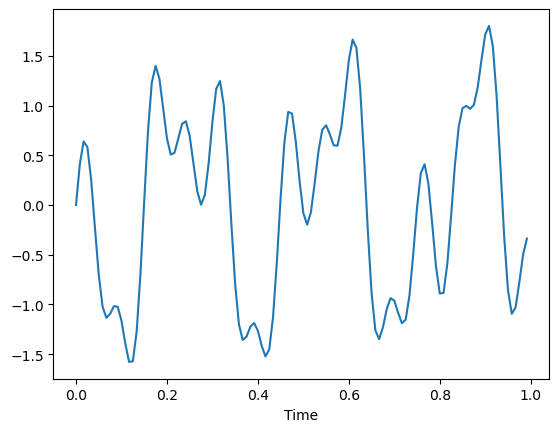

In [119]:
plt.plot(observations, target);
plt.xlabel("Time");

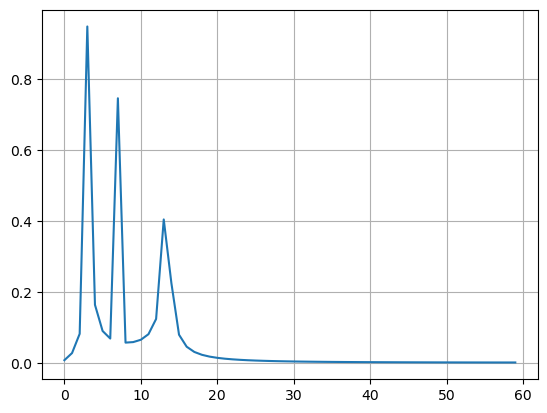

In [25]:
N = observation_resolution
T = 1.0 / N
yf = sp.fft.fft(target)
xf = sp.fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]));
plt.grid();
# plt.xlim(70, 72);

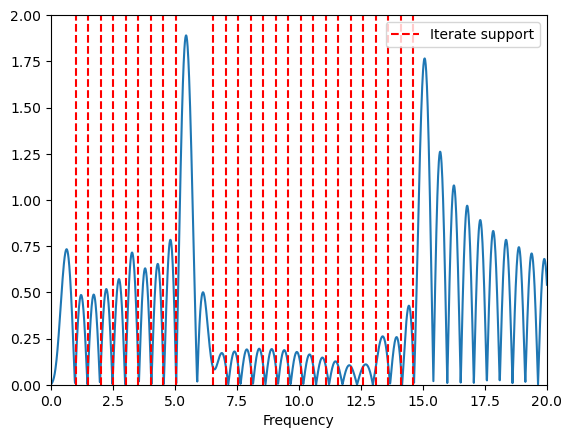

In [41]:
u_tilde = Measure(support=[[1.00840336],[1.51260504],[2.01680672],[2.5210084],[3.02521008],[3.52941176],[4.03361345],[4.53781513],[5.04201681],[6.52828034],[7.05882353],[7.56302521],[8.06722689],[8.57142857],[9.07563025],[9.57983193],[10.08403361],[10.58823529],[11.09243697],[11.59663866],[12.10084034],[12.60504202],[13.1092437],[13.61344538],[14.11764706],[14.62184874]], coefficients=[-0.02073555,0.03750054,-0.06643334,0.13918181,-0.92346277,-0.23878818,0.10786171,-0.06783396,0.04578576,0.04158428,0.72923855,-0.11325314,0.07786523,-0.06503374,0.05884924,-0.05590312,0.05517159,-0.05649383,0.06033915,-0.06817023,0.08409641,-0.123255,0.3144845,0.31918172,-0.08787151,0.04497542])
a = np.arange(Omega[0][0],Omega[0][1],0.01)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Iterate support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,2);
plt.xlim(0,20);
plt.legend();

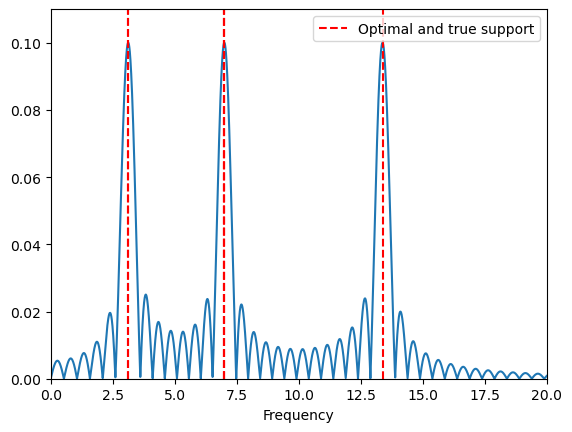

In [130]:
u_tilde = u # Measure(support=[[1.00840336],[1.51260504],[2.01680672],[2.5210084],[3.02521008],[3.52941176],[4.03361345],[4.53781513],[5.04201681],[6.52828034],[7.05882353],[7.56302521],[8.06722689],[8.57142857],[9.07563025],[9.57983193],[10.08403361],[10.58823529],[11.09243697],[11.59663866],[12.10084034],[12.60504202],[13.1092437],[13.61344538],[14.11764706],[14.62184874]], coefficients=[-0.02073555,0.03750054,-0.06643334,0.13918181,-0.92346277,-0.23878818,0.10786171,-0.06783396,0.04578576,0.04158428,0.72923855,-0.11325314,0.07786523,-0.06503374,0.05884924,-0.05590312,0.05517159,-0.05649383,0.06033915,-0.06817023,0.08409641,-0.123255,0.3144845,0.31918172,-0.08787151,0.04497542])
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_exact = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       1.50239772e-02, 8.58376237e-03, 6.60215195e-03, 6.26160449e-03,
       5.81056950e-03, 5.68714547e-03, 5.63453907e-03, 2.74798164e-03,
       2.49625303e-03, 2.43692851e-03, 1.09428954e-03, 1.06241336e-03,
       9.64583819e-04, 3.70010637e-04, 3.28227678e-04, 3.27716469e-04,
       1.08225413e-04, 8.89059416e-05, 8.85996710e-05, 2.08580979e-05,
       1.15859840e-05, 1.14112323e-05, 8.58446119e-06, 4.06824142e-06,
       3.96465096e-06, 2.55842018e-06, 1.39500283e-06, 1.33895562e-06,
       6.37729467e-07, 3.72189841e-07, 3.43277460e-07, 1.86415811e-07,
       1.07769274e-07, 9.30277860e-08, 4.47893356e-08, 3.13003693e-08,
       2.38715822e-08, 1.63305323e-08, 9.86911175e-09, 6.13658044e-09,
       2.36081441e-09, 2.29146599e-09, 4.21193497e-10, 3.30606542e-10,
       2.94933439e-10, 1.95398475e-10, 1.49766199e-10, 1.31618577e-10,
       8.15619794e-11, 5.86620474e-11, 4.95105901e-11, 2.44100018e-11,
       1.29377620e-11, 8.34271541e-12, 4.72957784e-12, 2.73697731e-12,
       1.81094029e-12, 0.00000000e+00])

times_exact = np.array([2.38418579e-07, 9.88021374e-01, 1.92760968e+00, 2.92872310e+00,
       4.06563377e+00, 5.21980023e+00, 6.45208216e+00, 7.77200389e+00,
       9.17736745e+00, 1.07096305e+01, 1.23069787e+01, 1.38361835e+01,
       1.53983567e+01, 1.69558151e+01, 1.82557144e+01, 1.95195346e+01,
       2.07822502e+01, 2.19258595e+01, 2.30997775e+01, 2.43279629e+01,
       2.54015219e+01, 2.65629263e+01, 2.77414117e+01, 2.89212012e+01,
       3.00694656e+01, 3.11982300e+01, 3.23421762e+01, 3.34845166e+01,
       3.46369295e+01, 3.57802386e+01, 3.69517639e+01, 3.81037898e+01,
       3.92542298e+01, 4.04111469e+01, 4.15864184e+01, 4.29164746e+01,
       4.40669634e+01, 4.52849309e+01, 4.64942343e+01, 4.78716824e+01,
       4.94829707e+01, 5.08883619e+01, 5.22283518e+01, 5.33525217e+01,
       5.45355294e+01, 5.56513226e+01, 5.68379409e+01, 5.80105677e+01,
       5.91760156e+01, 6.03169620e+01, 6.15967221e+01, 6.27649579e+01,
       6.39592140e+01, 6.50972443e+01, 6.62099152e+01, 6.73583612e+01,
       6.84970973e+01, 6.96487978e+01, 7.07916772e+01, 7.19246178e+01,
       7.30379057e+01, 7.42156003e+01])

supports_exact = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

residuals_newton = np.array([ 5.26929402e+01,  5.25620964e+01,  5.19870574e+01,  2.66276636e+01,
        2.24656226e+01,  2.23488531e+01,  2.22822380e+01,  2.20759943e+01,
        2.19514573e+01,  7.81828368e+00,  7.61331170e+00,  7.53508611e+00,
        7.45494061e+00,  7.51579966e+00,  7.39070991e+00,  7.07078834e+00,
        4.46967845e+00,  1.08436022e+00,  2.31045645e-01,  7.52489244e-02,
        4.03248275e-02,  3.32303530e-02,  3.13475816e-02,  3.00792392e-02,
        2.97608280e-02,  2.94543304e-02,  1.32952023e-01,  1.32632966e-01,
        1.31233459e-01,  1.26893317e-01,  1.25355805e-01,  1.18524340e-01,
        1.18248894e-01,  6.88252791e-02,  5.60988681e-02,  5.52574064e-02,
        5.42353627e-02,  5.25909403e-02,  5.06021111e-02,  4.89638581e-02,
        4.76547193e-02,  4.64563525e-02,  4.62013235e-02,  4.61208541e-02,
        4.60494976e-02,  4.59625504e-02,  4.21117135e-02,  3.84046185e-02,
        3.83263079e-02,  3.68536228e-02,  3.68069427e-02,  3.67882111e-02,
        3.63082252e-02,  3.60112387e-02,  3.58897077e-02,  3.19254081e-02,
        3.18990748e-02,  3.17999528e-02,  1.36324557e-02,  1.70134956e-01,
        2.56742288e-02,  2.53438224e-02,  2.41324706e-02,  2.18679971e-02,
        2.18287507e-02,  2.12778911e-02,  1.25388984e-02,  3.62175521e-01,
        3.62145009e-01,  3.61947493e-01,  3.61575678e-01,  1.41914862e-01,
        1.25478460e-02,  1.13816634e-02,  1.13470588e-02,  1.13294572e-02,
        8.92321860e-03,  8.89867384e-03,  1.41929019e-03,  4.76719047e-01,
        7.64804792e-04,  4.00067029e-05,  1.97182126e-05,  9.61567856e-06,
        4.59112497e-06,  2.08746219e-06,  4.40835948e-09, -1.54845581e-12,
       -1.54845581e-12, -1.54845581e-12])

times_newton = np.array([1.19209290e-06, 3.50530148e-02, 7.65721798e-02, 1.00760698e-01,
       1.40667200e-01, 1.93369150e-01, 2.26628065e-01, 2.60476351e-01,
       2.87328482e-01, 3.27580214e-01, 3.87232065e-01, 4.86147881e-01,
       6.57824755e-01, 7.84966707e-01, 8.73430967e-01, 9.55430984e-01,
       1.05128646e+00, 1.15954590e+00, 1.28845143e+00, 1.41336656e+00,
       3.33861947e+00, 5.16587710e+00, 5.95931125e+00, 8.06714368e+00,
       8.24223781e+00, 9.68999267e+00, 9.87122107e+00, 1.00135257e+01,
       1.01871917e+01, 1.03679237e+01, 1.05610576e+01, 1.07831032e+01,
       1.10229323e+01, 1.12856801e+01, 1.15844924e+01, 1.19650075e+01,
       1.23209784e+01, 1.26941075e+01, 1.31377363e+01, 1.35878024e+01,
       1.41198969e+01, 1.45857699e+01, 1.84010417e+01, 1.88914170e+01,
       1.95119765e+01, 2.07631366e+01, 2.20712292e+01, 2.33722093e+01,
       2.39961178e+01, 2.83172612e+01, 2.88574896e+01, 2.94551344e+01,
       3.07134571e+01, 3.28022921e+01, 3.40351858e+01, 3.59654481e+01,
       3.69288638e+01, 3.80622258e+01, 3.93214910e+01, 3.95796592e+01,
       3.98866813e+01, 4.00760870e+01, 4.02598145e+01, 4.04590158e+01,
       4.06475911e+01, 4.08621771e+01, 4.10804019e+01, 4.13060522e+01,
       4.13882751e+01, 4.14915731e+01, 4.16120453e+01, 4.17540088e+01,
       4.18768256e+01, 4.19658010e+01, 4.20636029e+01, 4.21780064e+01,
       4.25479925e+01, 4.29093494e+01, 4.33202276e+01, 4.33519595e+01,
       4.33971658e+01, 4.35446639e+01, 4.46824884e+01, 4.58495691e+01,
       4.69474213e+01, 4.80215468e+01, 4.81857424e+01, 4.91961775e+01,
       4.92172782e+01, 4.92342525e+01])

supports_newton = np.array([ 0,  1,  2,  3,  3,  3,  3,  4,  5,  5,  6,  6,  7,  6,  7,  8,  9,
       10, 10, 10, 11, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 18, 19, 20,
       20, 21, 22, 22, 22, 23, 24, 24, 25, 26, 27, 28, 28, 27, 28, 26, 27,
       28, 28, 28, 28, 26, 27, 27, 21, 19, 17, 17, 17, 17, 18, 18, 18, 10,
       11, 12, 13, 14, 10, 10, 11, 12, 12, 13,  7,  5,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3])

residuals_newton_damped = np.array([ 5.26929402e+01,  5.25620964e+01,  5.19870574e+01,  2.66276636e+01,
        2.57543305e+01,  2.50903252e+01,  2.45653589e+01,  2.41412240e+01,
        2.37941012e+01,  2.35078041e+01,  2.32706586e+01,  2.30738724e+01,
        2.29106061e+01,  2.27754076e+01,  2.26638494e+01,  2.25722857e+01,
        2.24976823e+01,  2.24374926e+01,  2.22527860e+01,  2.19286447e+01,
        2.18657876e+01,  7.81269286e+00,  7.61407181e+00,  7.53947553e+00,
        7.46153050e+00,  7.32301995e+00,  6.97280051e+00,  4.27636615e+00,
        9.96507254e-01,  6.94466262e-01,  5.48823234e-01,  4.75508849e-01,
        3.24260159e-01,  2.60875987e-01,  2.36777352e-01,  1.74305780e-01,
        1.59399449e-01,  1.36604334e-01,  1.28257730e-01,  1.24369710e-01,
        1.21452078e-01,  1.17626324e-01,  1.15894192e-01,  1.14831367e-01,
        1.14368402e-01,  1.13187605e-01,  1.12771337e-01,  1.12536257e-01,
        1.12397546e-01,  1.12289331e-01,  1.04034527e-01,  1.03427470e-01,
        1.03346617e-01,  1.00061671e-01,  4.37470350e-02,  4.25330527e-02,
        4.23457262e-02,  3.73559638e-02,  3.71899319e-02,  3.67949813e-02,
        3.62619166e-02,  3.60734907e-02,  3.51426068e-02,  3.46062988e-02,
        3.45004973e-02,  3.39155825e-02,  3.36285676e-02,  3.35109183e-02,
        3.33679303e-02,  3.32021673e-02,  3.28601846e-02,  2.70326470e-02,
        5.54262458e-02,  4.15362193e-02,  4.14902063e-02,  4.02877004e-02,
        3.34507633e-02,  3.27184290e-02,  3.26134829e-02,  3.20465945e-02,
        3.20359021e-02,  3.19992611e-02,  3.18567049e-02,  3.04076604e-02,
        3.02365517e-02,  2.99306178e-02,  2.68251909e-02,  2.07420017e-02,
        5.50570375e-02,  3.14172461e-02,  2.22514305e-02,  2.22249575e-02,
        2.15407103e-02,  1.49961340e-02,  1.49718809e-02,  1.46584673e-02,
        1.22579881e+00,  9.69450082e-01,  7.66135071e-01,  6.04323374e-01,
        4.73626012e-01,  4.73588329e-01,  4.73061803e-01,  4.64688307e-01,
        3.90282873e-01,  3.31211198e-01,  3.28993807e-01,  3.28560768e-01,
        3.27098713e-01,  3.21537913e-01,  3.18783661e-01,  3.07384133e-01,
        2.91361916e-01,  2.67452526e-01,  2.66925209e-01,  2.60643039e-01,
        1.43521230e-01,  1.42189035e-01,  1.41065764e-01,  1.41049824e-01,
        1.40692076e-01,  1.40590950e-01,  1.40580299e-01,  1.40246020e-01,
        1.36922458e-01,  1.36878456e-01,  7.85498013e-02,  7.85338995e-02,
        7.76072178e-02,  7.70825845e-02,  7.66377201e-02,  7.61978735e-02,
        7.57809870e-02,  7.56713526e-02,  7.56285106e-02,  7.52632378e-02,
        7.45036164e-02,  7.44631938e-02,  7.28254945e-02,  3.31248378e-02,
        3.20137602e-02,  3.19904312e-02,  3.18434606e-02,  3.04579202e-02,
        3.02541430e-02,  3.02066381e-02,  3.01943412e-02,  3.00214921e-02,
        2.99741494e-02,  2.99638134e-02,  2.99513066e-02,  2.99325549e-02,
        2.99069365e-02,  2.98111669e-02,  1.04629512e-02,  7.39730802e-01,
        5.64536218e-01,  4.30489609e-01,  3.25729864e-01,  2.45867556e-01,
        1.87775754e-01,  1.87630064e-01,  1.87190624e-01,  1.86442345e-01,
        1.81406565e-01,  1.81327942e-01,  1.72956246e-01,  1.58589893e-01,
        1.58533821e-01,  1.31196163e-01,  7.00831908e-02,  6.95417743e-02,
        6.91604417e-02,  6.88524760e-02,  6.85725791e-02,  6.82904099e-02,
        6.79776201e-02,  6.76004146e-02,  6.71274211e-02,  6.67262665e-02,
        2.31821061e-02,  2.31712064e-02,  2.27061975e-02,  2.26932704e-02,
        2.21145877e-02,  2.21039197e-02,  1.55342331e-02,  1.46358171e-02,
        1.45134952e-02,  1.45001800e-02,  1.44899631e-02,  1.43927573e-02,
        6.86463266e-03,  1.01083550e+00,  1.00981821e+00,  1.00356159e+00,
        9.83544464e-01,  9.29486975e-01,  3.55793428e-01,  3.14232999e-01,
        2.96314043e-01,  2.84893094e-01,  2.75421116e-01,  2.64427863e-01,
        2.20510971e-01,  2.20236920e-01,  2.17606825e-01,  1.99516824e-01,
        1.94419677e-01,  1.93183791e-01,  1.64403150e-01,  1.60182018e-01,
        1.60086991e-01,  1.46701651e-01,  1.46553655e-01,  1.46532112e-01,
        1.46277385e-01,  1.28652377e-01,  1.28624993e-01,  1.28509064e-01,
        1.28206787e-01,  1.26982764e-01,  1.26890825e-01,  1.26855809e-01,
        1.26526395e-01,  1.26505494e-01,  1.26415862e-01,  1.19859654e-01,
        1.18708134e-01,  1.18074409e-01,  1.17942273e-01,  1.17929377e-01,
        1.16624841e-01,  1.16608937e-01,  1.12303764e-01,  6.33258710e-02,
        6.30558533e-02,  6.29588708e-02,  5.48977016e-02,  5.47981071e-02,
        5.45506534e-02,  3.04094490e-02,  3.00268949e-02,  2.98111645e-02,
        2.97714409e-02,  2.84510439e-02,  2.84266352e-02,  2.82042827e-02,
        2.80109069e-02,  2.76661803e-02,  2.75536035e-02,  2.73865280e-02,
        2.67305286e-02,  2.67151698e-02,  2.47657038e-02,  2.40859589e-02,
        6.85260683e-03,  6.75051478e-03,  6.74330740e-03,  6.56765994e-03,
        6.54826276e-03,  6.49534390e-03,  6.49375784e-03,  2.21336094e-03,
        3.77204047e+00,  2.99265590e+00,  2.39294549e+00,  1.91904408e+00,
        1.54970094e+00,  1.23663539e+00,  9.84295043e-01,  7.81729556e-01,
        6.33028103e-01,  4.82594337e-01,  3.59632584e-01,  2.60514488e-01,
        1.84771191e-01,  1.26298896e-01,  1.26234053e-01,  1.25801550e-01,
        1.24019818e-01,  1.15684674e-01,  4.28485030e-02,  3.50346534e-02,
        3.50339009e-02,  3.49784628e-02,  3.17848200e-02,  3.17825308e-02,
        2.91402785e-02,  2.66115608e-02,  2.42966438e-02,  2.16564330e-02,
        1.88151175e-02,  1.80923773e-02,  1.17088635e-02,  1.16390191e-02,
        1.15685685e-02,  1.15536719e-02,  1.14689956e-02,  1.07555422e-02,
        2.59274725e-03,  2.56363370e-03,  2.55483794e-03,  2.46665836e-03,
        2.46393750e-03,  2.45484975e-03,  2.44113645e-03,  7.80117406e-04,
        1.82967089e+00,  1.36702190e+00,  1.02136990e+00,  7.58252760e-01,
        5.56798369e-01,  4.02903999e-01,  2.86345536e-01,  1.99368917e-01,
        1.36003456e-01,  9.22157234e-02,  9.21602730e-02,  8.81753298e-02,
        4.44018869e-02,  2.40700741e-02,  1.21154364e-02,  5.38455009e-03,
        2.00523803e-03,  5.71802234e-04,  1.05236778e-04,  8.67977553e-06,
        1.34568189e-07,  4.93839691e-11, -1.54837254e-12, -1.54845581e-12])

times_newton_damped = np.array([2.38418579e-07, 5.88369370e-03, 1.63602829e-02, 3.94928455e-02,
       7.92682171e-02, 1.24153137e-01, 1.67681694e-01, 2.10823298e-01,
       2.52783537e-01, 2.95815945e-01, 3.38614702e-01, 3.78114223e-01,
       4.17295218e-01, 4.62554216e-01, 5.04990339e-01, 5.49395323e-01,
       5.94838858e-01, 6.38618469e-01, 6.95864201e-01, 7.26849079e-01,
       7.81159401e-01, 8.50107193e-01, 9.19887304e-01, 1.00283051e+00,
       1.11591029e+00, 1.24646115e+00, 1.39396429e+00, 1.55571365e+00,
       1.72874546e+00, 1.90935731e+00, 2.12030363e+00, 2.33188939e+00,
       2.94162989e+00, 5.23218584e+00, 5.46177506e+00, 5.71456528e+00,
       6.41008353e+00, 7.26161218e+00, 1.01979020e+01, 1.05745559e+01,
       1.09896424e+01, 1.19573908e+01, 1.54089293e+01, 1.57898455e+01,
       1.62298830e+01, 1.66762693e+01, 1.86149774e+01, 2.32094271e+01,
       2.37065125e+01, 2.49789090e+01, 2.63867519e+01, 2.70059228e+01,
       2.76308749e+01, 2.83175905e+01, 2.98184423e+01, 3.03312495e+01,
       3.07565784e+01, 3.12302687e+01, 3.15632522e+01, 3.19777145e+01,
       3.24312148e+01, 3.28638802e+01, 3.37700245e+01, 3.46222157e+01,
       3.55151978e+01, 3.72617400e+01, 3.88958638e+01, 3.98125980e+01,
       4.09351780e+01, 4.27326491e+01, 4.38917081e+01, 4.80937045e+01,
       4.85667012e+01, 4.88779118e+01, 4.92821441e+01, 4.96434917e+01,
       5.00389259e+01, 5.03963103e+01, 5.07589023e+01, 5.11848614e+01,
       5.21302207e+01, 5.32085662e+01, 5.42094820e+01, 5.52728546e+01,
       5.63297958e+01, 5.75156987e+01, 5.85502603e+01, 5.94508607e+01,
       5.97788539e+01, 6.01025312e+01, 6.03246636e+01, 6.04761484e+01,
       6.06263611e+01, 6.08357768e+01, 6.10266192e+01, 6.12543473e+01,
       6.14634323e+01, 6.16085811e+01, 6.17436318e+01, 6.18790925e+01,
       6.20143988e+01, 6.21551433e+01, 6.23561687e+01, 6.26119637e+01,
       6.28419385e+01, 6.30608089e+01, 6.32263832e+01, 6.34177706e+01,
       6.35880885e+01, 6.37820282e+01, 6.39754448e+01, 6.42220516e+01,
       6.44511318e+01, 6.48125246e+01, 6.50816958e+01, 6.53704171e+01,
       6.56647878e+01, 6.58567896e+01, 6.60778272e+01, 6.63093851e+01,
       6.65389431e+01, 6.67539840e+01, 6.70030527e+01, 6.72904878e+01,
       6.75893922e+01, 6.79415443e+01, 6.84400933e+01, 6.86929250e+01,
       6.89406965e+01, 6.92002592e+01, 6.95031140e+01, 6.97808478e+01,
       7.00735068e+01, 7.03189948e+01, 7.06356940e+01, 7.09803288e+01,
       7.13522956e+01, 7.17382686e+01, 7.21562939e+01, 7.25905116e+01,
       7.27341890e+01, 7.29055538e+01, 7.31368921e+01, 7.34065645e+01,
       7.36617687e+01, 7.38862233e+01, 7.41379080e+01, 7.44507113e+01,
       7.49304247e+01, 7.57424572e+01, 7.65489047e+01, 7.75408275e+01,
       7.84397461e+01, 7.94006407e+01, 8.04381185e+01, 8.05899518e+01,
       8.07071223e+01, 8.08188837e+01, 8.09324994e+01, 8.10526922e+01,
       8.11753182e+01, 8.12847002e+01, 8.14194565e+01, 8.15601122e+01,
       8.17000353e+01, 8.18399365e+01, 8.20999794e+01, 8.23351896e+01,
       8.25357878e+01, 8.28019390e+01, 8.31766996e+01, 8.32893560e+01,
       8.34473858e+01, 8.35854576e+01, 8.37491596e+01, 8.39245653e+01,
       8.41336677e+01, 8.43643386e+01, 8.46268134e+01, 8.49189832e+01,
       8.52259951e+01, 8.53467150e+01, 8.54884417e+01, 8.56170011e+01,
       8.57828584e+01, 8.59666712e+01, 8.61874168e+01, 8.63552811e+01,
       8.65290616e+01, 8.67225938e+01, 8.72482383e+01, 8.78819907e+01,
       8.85711277e+01, 8.86888502e+01, 8.87994392e+01, 8.89192851e+01,
       8.90138583e+01, 8.91190856e+01, 8.92451961e+01, 8.93598199e+01,
       8.95005546e+01, 8.97097170e+01, 8.99256668e+01, 9.01271601e+01,
       9.02715683e+01, 9.04125407e+01, 9.05869627e+01, 9.08195376e+01,
       9.10751116e+01, 9.13652904e+01, 9.16522615e+01, 9.19981673e+01,
       9.24341245e+01, 9.28161924e+01, 9.31593404e+01, 9.35580618e+01,
       9.40004685e+01, 9.45103705e+01, 9.49612072e+01, 9.55410442e+01,
       9.59798584e+01, 9.65517249e+01, 9.70987732e+01, 9.76313846e+01,
       9.82400188e+01, 9.88334110e+01, 9.95688486e+01, 1.00731904e+02,
       1.01898478e+02, 1.03104079e+02, 1.03545655e+02, 1.04267986e+02,
       1.05520545e+02, 1.06070279e+02, 1.07270076e+02, 1.08391880e+02,
       1.08864780e+02, 1.09295051e+02, 1.09716770e+02, 1.10139763e+02,
       1.10620347e+02, 1.11522727e+02, 1.11732380e+02, 1.11963297e+02,
       1.12263504e+02, 1.12889710e+02, 1.13497005e+02, 1.14173733e+02,
       1.14665878e+02, 1.15411927e+02, 1.16152309e+02, 1.16918021e+02,
       1.17742764e+02, 1.19569198e+02, 1.23203266e+02, 1.23466244e+02,
       1.24172325e+02, 1.24317539e+02, 1.24501564e+02, 1.25069202e+02,
       1.25559387e+02, 1.26121090e+02, 1.28493523e+02, 1.29183371e+02,
       1.29269421e+02, 1.29363413e+02, 1.29456418e+02, 1.29540064e+02,
       1.29593195e+02, 1.29644550e+02, 1.29697870e+02, 1.29748629e+02,
       1.29797975e+02, 1.29887566e+02, 1.29992473e+02, 1.30076251e+02,
       1.30142621e+02, 1.30211163e+02, 1.30281438e+02, 1.30372108e+02,
       1.30426451e+02, 1.30491740e+02, 1.30580629e+02, 1.30632640e+02,
       1.30686710e+02, 1.30756545e+02, 1.30840637e+02, 1.30926390e+02,
       1.31038929e+02, 1.31153222e+02, 1.31281767e+02, 1.31422207e+02,
       1.31559954e+02, 1.31706261e+02, 1.31870461e+02, 1.32001415e+02,
       1.32150305e+02, 1.32332479e+02, 1.32761228e+02, 1.33222218e+02,
       1.33382294e+02, 1.33441084e+02, 1.33497789e+02, 1.33746444e+02,
       1.33988126e+02, 1.34260027e+02, 1.34522585e+02, 1.35077284e+02,
       1.35108308e+02, 1.35140305e+02, 1.35171854e+02, 1.35203721e+02,
       1.35235882e+02, 1.35274211e+02, 1.35313801e+02, 1.35358469e+02,
       1.35399189e+02, 1.35435642e+02, 1.35471655e+02, 1.35517866e+02,
       1.35569836e+02, 1.35607206e+02, 1.35629487e+02, 1.35653841e+02,
       1.35678318e+02, 1.35703684e+02, 1.35729129e+02, 1.35756085e+02,
       1.36777614e+02, 1.37790061e+02, 1.37801532e+02, 1.37813245e+02])

supports_newton_damped = np.array([ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 11, 12, 13, 14, 14, 15, 16, 17,
       17, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 30,
       30, 31, 30, 28, 25, 26, 21, 22, 23, 23, 24, 24, 24, 25, 25, 24, 25,
       26, 26, 26, 25, 21, 22, 23, 24, 22, 22, 23, 23, 24, 25, 26, 26, 27,
       26, 23, 21, 20, 19, 13, 14, 15, 14, 15, 16, 14, 14, 14, 14, 14, 15,
       16, 16, 16, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 14, 14, 14,
       15, 16, 17, 18, 19, 19, 20, 18, 18, 17, 18, 19, 19, 20, 20, 21, 22,
       23, 24, 23, 14, 14, 15, 16, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 14, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 15, 16, 17, 18, 19,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 14, 15, 14, 15, 14, 15, 14,
       13, 14, 15, 16, 17, 12,  9, 10, 11, 12, 13, 13, 14, 14, 15, 14, 14,
       15, 16, 17, 17, 18, 19, 18, 19, 20, 21, 22, 23, 24, 22, 23, 24, 25,
       26, 27, 28, 29, 29, 30, 30, 30, 28, 28, 29, 28, 29, 28, 28, 28, 27,
       24, 25, 24, 18, 18, 18, 19, 19, 20, 20, 21, 20, 21, 21, 21, 22, 21,
       20, 14, 15, 16, 16, 16, 16, 17, 10,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  6,  5,  5,  5,  6,  7,  8,  9,  7,  8,  9, 10, 11, 12, 12,
       13, 13, 13, 13, 14, 12, 13, 13, 14, 14, 13,  8,  9,  9,  8,  9,  9,
        9,  8,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  7,  5,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3])

residuals_lpdap = np.array([ 5.26929402e+01,  5.26929402e+01,  5.25620964e+01,  5.19870574e+01,
        2.66276636e+01,  2.49276716e+01,  2.45793966e+01,  2.44406749e+01,
        2.43765477e+01,  8.64820611e+00,  8.27418405e+00,  8.09740213e+00,
        7.97389513e+00,  7.87258436e+00,  7.78100341e+00,  7.69164880e+00,
        7.59779599e+00,  7.49053910e+00,  7.35337633e+00,  7.14421789e+00,
        6.69394774e+00,  3.75567232e+00,  7.21010839e-01,  4.90307984e-01,
        4.29650361e-01,  3.78507686e-01,  3.65716428e-01,  3.23879899e-01,
        3.00479089e-01,  2.78331511e-01,  2.68853236e-01,  2.64865870e-01,
        2.58778833e-01,  2.56324778e-01,  2.54179739e-01,  2.53530427e-01,
        2.52263666e-01,  2.25886071e-01,  2.25886071e-01,  2.25886071e-01,
        2.25886071e-01,  2.25886071e-01,  2.24824681e-01,  2.24252231e-01,
        2.12459455e-01,  1.73031009e-01,  1.61355209e-01,  1.59763892e-01,
        1.58574532e-01,  1.57669790e-01,  1.56972650e-01,  1.56430305e-01,
        1.55734113e-01,  8.04692147e-02,  7.80824779e-02,  7.51790978e-02,
        7.50794749e-02,  7.49165530e-02,  7.35113364e-02,  7.35113364e-02,
        7.35113364e-02,  7.35113364e-02,  7.34562603e-02,  7.02510263e-02,
        6.99864980e-02,  6.90823929e-02,  6.90398806e-02,  6.89737859e-02,
        5.03134086e-02,  5.03134086e-02,  5.03134086e-02,  4.81296572e-02,
        4.81296572e-02,  2.67866345e-02,  2.67778682e-02,  2.67532929e-02,
        2.66106237e-02,  2.64917083e-02,  2.64294517e-02,  2.61043679e-02,
        2.60881518e-02,  2.57800636e-02,  2.57518117e-02,  2.57088797e-02,
        1.01380127e-02,  1.01342093e-02,  9.96706452e-03,  9.96526671e-03,
        9.95853289e-03,  4.85369832e-03,  4.85007548e-03,  4.84929157e-03,
        2.17201963e-03,  2.17171661e-03,  1.75206476e-03,  1.75206476e-03,
        1.40242541e-03,  1.40242541e-03,  1.40242541e-03,  1.40242541e-03,
        1.40242541e-03,  1.40242541e-03,  1.40242541e-03,  4.89145677e-04,
        3.96210299e-04,  3.96210299e-04,  3.96210299e-04,  3.96210299e-04,
        2.74899826e-04,  1.51265967e-04,  1.51265967e-04,  1.51265967e-04,
        1.51265967e-04,  1.13336221e-04,  6.50056078e-05,  6.50056078e-05,
        3.26253363e-05,  3.26253363e-05,  2.49907284e-05,  1.24194015e-05,
        8.38452004e-06,  8.38452004e-06,  8.38452004e-06,  6.01126479e-06,
        3.84683960e-06,  1.84965153e-06,  1.50983451e-06,  5.35190511e-07,
        3.58658009e-07,  1.88247003e-07,  6.52210501e-08,  1.90385630e-08,
        6.47917403e-09,  1.13605739e-09,  4.01293387e-10,  1.89082972e-10,
        5.66243996e-11,  2.95099500e-11,  1.90312766e-11,  4.86385932e-12,
       -6.70130618e-13, -1.05776499e-12, -1.10234044e-12, -1.24153465e-12,
       -1.45994328e-12])

times_lpdap = np.array([4.76837158e-07, 6.60204887e-03, 2.54011154e-02, 5.60369492e-02,
       1.07898235e-01, 1.69860363e-01, 2.48097420e-01, 3.39205027e-01,
       4.82239008e-01, 6.05347872e-01, 6.93174362e-01, 7.75243759e-01,
       8.30967903e-01, 8.90423775e-01, 9.57917213e-01, 1.04224110e+00,
       1.35270810e+00, 1.47868872e+00, 1.58496833e+00, 1.69577765e+00,
       1.82250381e+00, 1.98192668e+00, 2.14147735e+00, 2.31026173e+00,
       5.74070048e+00, 5.83775115e+00, 5.91247010e+00, 6.04834962e+00,
       6.26209116e+00, 1.05223665e+01, 1.08282108e+01, 1.15753076e+01,
       1.25506306e+01, 1.75077856e+01, 1.77495985e+01, 1.81649315e+01,
       1.90849392e+01, 1.94089470e+01, 1.97365661e+01, 2.00660965e+01,
       2.04215944e+01, 2.07546794e+01, 2.11152954e+01, 2.23178980e+01,
       2.34266613e+01, 2.35310397e+01, 2.39241705e+01, 2.42948279e+01,
       2.46708720e+01, 2.50720842e+01, 2.54874530e+01, 2.66499705e+01,
       2.82441063e+01, 2.84605238e+01, 3.41781743e+01, 3.43453023e+01,
       3.44999065e+01, 3.46667595e+01, 3.56602511e+01, 3.66339037e+01,
       3.76608882e+01, 3.85991008e+01, 3.96723380e+01, 4.07227504e+01,
       4.18294492e+01, 4.28769896e+01, 4.38937817e+01, 4.96671469e+01,
       5.04948776e+01, 5.13156676e+01, 5.21427960e+01, 5.30157297e+01,
       5.39249063e+01, 5.41700602e+01, 5.48967578e+01, 5.59489701e+01,
       5.67295394e+01, 5.75899749e+01, 5.84158933e+01, 5.91859059e+01,
       6.04404628e+01, 6.11731324e+01, 6.46336293e+01, 6.53371570e+01,
       6.58819618e+01, 6.64087350e+01, 6.65591221e+01, 6.79277844e+01,
       6.92337589e+01, 6.96758428e+01, 7.20805249e+01, 7.25093572e+01,
       7.28234413e+01, 7.35390162e+01, 7.51716452e+01, 7.66230180e+01,
       7.68254173e+01, 7.70242369e+01, 7.72247398e+01, 7.74236872e+01,
       7.76473427e+01, 7.79152105e+01, 7.81766312e+01, 7.95202086e+01,
       7.95461404e+01, 7.95687070e+01, 7.95928388e+01, 7.96181083e+01,
       7.96475408e+01, 8.09319434e+01, 8.22892053e+01, 8.37554312e+01,
       8.52223849e+01, 8.52480509e+01, 8.52710395e+01, 8.52961378e+01,
       8.65317848e+01, 8.78393950e+01, 8.78803828e+01, 8.79307518e+01,
       8.93194730e+01, 9.07098999e+01, 9.21416535e+01, 9.21699152e+01,
       9.21979632e+01, 9.35726988e+01, 9.36050687e+01, 9.36362853e+01,
       9.49261038e+01, 9.49586608e+01, 9.62786772e+01, 9.75519636e+01,
       9.88441787e+01, 1.00184033e+02, 1.01544605e+02, 1.01573754e+02,
       1.02944514e+02, 1.04228276e+02, 1.04257042e+02, 1.05564865e+02,
       1.07046253e+02, 1.07081015e+02, 1.08503597e+02, 1.08542952e+02,
       1.09970994e+02])

supports_lpdap = np.array([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 36, 36, 36, 36, 37, 38, 37, 37, 36, 37, 38, 39, 40,
       41, 42, 39, 38, 34, 34, 35, 34, 34, 34, 34, 35, 34, 34, 34, 35, 36,
       30, 30, 30, 30, 30, 26, 27, 28, 28, 28, 27, 23, 23, 23, 23, 23, 20,
       20, 19, 20, 21, 15, 16, 17, 11, 12, 10, 10,  8,  8,  8,  8,  8,  8,
        8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 527);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_exact, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_exact, times_lpdap, times_newton, times_newton_damped], [residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 26);
plt.legend();